In [8]:
import os
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape
from tensorflow.keras import optimizers
from tensorflow.keras.applications.efficientnet import decode_predictions
from efficientnet.tfkeras import EfficientNetB5, preprocess_input
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from deep_svdd import BaseSVDD
import cv2
import MVTecAD_loaddata as mv
import pandas as pd


acc = []

ImportError: cannot import name 'Functional' from 'tensorflow.keras.models' (C:\Users\Shuta Tsuchio\anaconda3\envs\SHUTA\lib\site-packages\keras\api\_v2\keras\models\__init__.py)

In [7]:
model = Functional()
model.add(EfficientNetB5(include_top=False,weights='imagenet', input_shape=(256,256,3)))

NameError: name 'Functional' is not defined

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functiona  (None, 8, 8, 2048)        28513520  
 l)                                                              
                                                                 
Total params: 28513520 (108.77 MB)
Trainable params: 28340784 (108.11 MB)
Non-trainable params: 172736 (674.75 KB)
_________________________________________________________________


In [5]:
X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()

In [7]:
x_tr = model.predict(X_train)
x_ts = model.predict(X_test)


3/3 [==============================] - 15s 5s/step


In [12]:
x_tr = x_tr.reshape(x_tr.shape[0],-1)
x_ts = x_ts.reshape(x_ts.shape[0],-1)

In [17]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

In [24]:
svdd = BaseSVDD(C=2**(-1), gamma=10**(-4), kernel='rbf', display='on')
svdd.fit(x_tr)
pred = svdd.predict(x_ts, y_ts)
dist = svdd.get_distance(x_ts)
dist = np.asarray(dist)
a = np.where(y_ts < 0, 1, 0)
r1 = roc_auc_score(a, dist)
r2 = f1_score(y_ts, pred)
r3 = accuracy_score(y_ts, pred)
print('roc_auc : ',r1)
print('f1_score : ', r2)
print('accuracy_score : ', r3)



*** Fitting of the SVDD model is completed. ***

running time         = 5.8771 seconds
kernel function      = rbf
iterations           = 10
radius               = 0.8249
number of samples    = 209
number of features   = 131072
number of SVs        = 25
ratio of SVs         = 11.9617 %
accuracy             = 88.9952 %




*** Prediction of the provided data is completed. ***

running time         = 2.2128 seconds
number of samples    = 83
number of alarm      = 70
accuracy             = 91.5663 %


roc_auc :  0.996031746031746
f1_score :  0.787878787878788
accuracy_score :  0.9156626506024096


In [23]:
%%time
for num in range(5):
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="mean_squared_error", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))
    
    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
2/2 [==============================] - 69s 27s/step - loss: 0.1321 - accuracy: 0.4010 - val_loss: 0.1319 - val_accuracy: 0.3959
Epoch 2/10
2/2 [==============================] - 31s 24s/step - loss: 0.1315 - accuracy: 0.3976 - val_loss: 0.1317 - val_accuracy: 0.3985
Epoch 3/10
2/2 [==============================] - 31s 24s/step - loss: 0.1310 - accuracy: 0.3966 - val_loss: 0.1316 - val_accuracy: 0.4008
Epoch 4/10
2/2 [==============================] - 31s 24s/step - loss: 0.1302 - accuracy: 0.3926 - val_loss: 0.1313 - val_accuracy: 0.4004
Epoch 5/10
2/2 [==============================] - 31s 23s/step - loss: 0.1284 - accuracy: 0.3877 - val_loss: 0.1308 - val_accuracy: 0.3978
Epoch 6/10
2/2 [==============================] - 32s 24s/step - loss: 0.1253 - accuracy: 0.3839 - val_loss: 0.1299 - val_accuracy: 0.3947
Epoch 7/10
2/2 [==============================] - 33s 23s/step - loss: 0.1207 - accuracy: 0.3810 - val_loss: 0.1284 - val_accuracy: 0.3907
Epoch 8/10



KeyboardInterrupt



Epoch 1/10
2/2 [==============================] - 53s 31s/step - loss: 1.3297 - accuracy: 0.1942 - val_loss: 1.3278 - val_accuracy: 0.2458
Epoch 2/10
2/2 [==============================] - 38s 28s/step - loss: 1.3286 - accuracy: 0.2555 - val_loss: 1.3270 - val_accuracy: 0.3138
Epoch 3/10
2/2 [==============================] - 38s 28s/step - loss: 1.3277 - accuracy: 0.3242 - val_loss: 1.3263 - val_accuracy: 0.3828
Epoch 4/10
2/2 [==============================] - 37s 28s/step - loss: 1.3271 - accuracy: 0.3904 - val_loss: 1.3257 - val_accuracy: 0.4454
Epoch 5/10
2/2 [==============================] - 37s 28s/step - loss: 1.3274 - accuracy: 0.4486 - val_loss: 1.3252 - val_accuracy: 0.4985
Epoch 6/10
2/2 [==============================] - 37s 28s/step - loss: 1.3302 - accuracy: 0.4976 - val_loss: 1.3254 - val_accuracy: 0.5418
Epoch 7/10
2/2 [==============================] - 38s 29s/step - loss: 1.3398 - accuracy: 0.5368 - val_loss: 1.3265 - val_accuracy: 0.5741
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3490 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9792
number of samples    = 224
number of features   = 90112
number of SVs        = 136
ratio of SVs         = 60.7143 %
accuracy             = 92.8571 %




*** Prediction of the provided data is completed. ***

running time         = 0.8766 seconds
number of samples    = 82
number of alarm      = 81
accuracy             = 98.7805 %




*** Prediction of the provided data is completed. ***

running time         = 0.7595 seconds
number of samples    = 58
number of alarm      = 28
accuracy             = 51.7241 %




*** Prediction of the provided data is completed. ***

running time         = 1.2964 seconds
number of samples    = 140
number of alarm      = 109
accuracy             = 79.2857 %




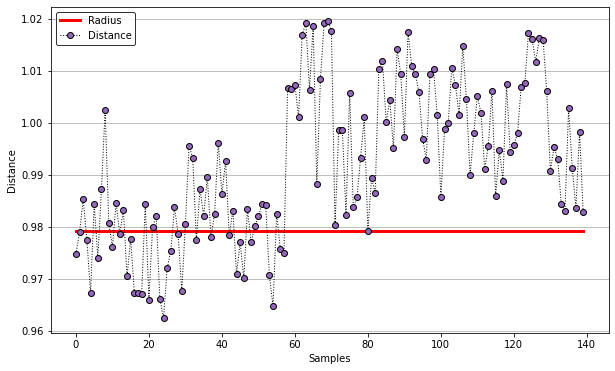

Epoch 1/10
2/2 [==============================] - 54s 32s/step - loss: 1.3265 - accuracy: 0.1603 - val_loss: 1.3301 - val_accuracy: 0.2127
Epoch 2/10
2/2 [==============================] - 40s 30s/step - loss: 1.3242 - accuracy: 0.2317 - val_loss: 1.3288 - val_accuracy: 0.2901
Epoch 3/10
2/2 [==============================] - 39s 29s/step - loss: 1.3229 - accuracy: 0.3173 - val_loss: 1.3279 - val_accuracy: 0.3688
Epoch 4/10
2/2 [==============================] - 38s 29s/step - loss: 1.3221 - accuracy: 0.3984 - val_loss: 1.3271 - val_accuracy: 0.4417
Epoch 5/10
2/2 [==============================] - 39s 29s/step - loss: 1.3224 - accuracy: 0.4652 - val_loss: 1.3267 - val_accuracy: 0.5042
Epoch 6/10
2/2 [==============================] - 39s 29s/step - loss: 1.3249 - accuracy: 0.5209 - val_loss: 1.3267 - val_accuracy: 0.5517
Epoch 7/10
2/2 [==============================] - 39s 29s/step - loss: 1.3334 - accuracy: 0.5617 - val_loss: 1.3277 - val_accuracy: 0.5806
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3373 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9785
number of samples    = 224
number of features   = 90112
number of SVs        = 141
ratio of SVs         = 62.9464 %
accuracy             = 93.7500 %




*** Prediction of the provided data is completed. ***

running time         = 0.8837 seconds
number of samples    = 82
number of alarm      = 82
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.6802 seconds
number of samples    = 58
number of alarm      = 26
accuracy             = 55.1724 %




*** Prediction of the provided data is completed. ***

running time         = 1.3714 seconds
number of samples    = 140
number of alarm      = 108
accuracy             = 81.4286 %




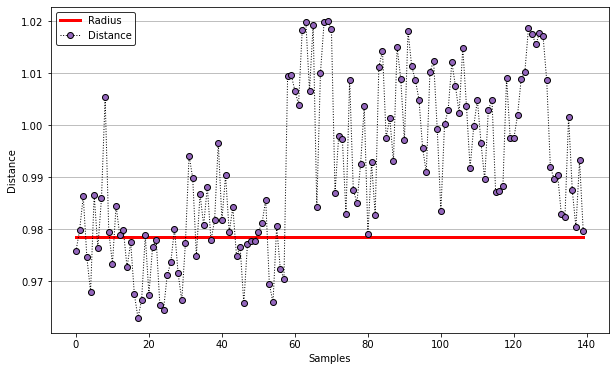

Epoch 1/10
2/2 [==============================] - 56s 32s/step - loss: 1.3092 - accuracy: 0.6361 - val_loss: 1.3271 - val_accuracy: 0.6587
Epoch 2/10
2/2 [==============================] - 39s 30s/step - loss: 1.3080 - accuracy: 0.6566 - val_loss: 1.3264 - val_accuracy: 0.6741
Epoch 3/10
2/2 [==============================] - 39s 29s/step - loss: 1.3072 - accuracy: 0.6696 - val_loss: 1.3258 - val_accuracy: 0.6839
Epoch 4/10
2/2 [==============================] - 38s 29s/step - loss: 1.3069 - accuracy: 0.6772 - val_loss: 1.3253 - val_accuracy: 0.6890
Epoch 5/10
2/2 [==============================] - 39s 29s/step - loss: 1.3093 - accuracy: 0.6800 - val_loss: 1.3250 - val_accuracy: 0.6898
Epoch 6/10
2/2 [==============================] - 40s 30s/step - loss: 1.3182 - accuracy: 0.6809 - val_loss: 1.3252 - val_accuracy: 0.6871
Epoch 7/10
2/2 [==============================] - 38s 29s/step - loss: 1.3311 - accuracy: 0.6780 - val_loss: 1.3260 - val_accuracy: 0.6813
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2717 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9763
number of samples    = 224
number of features   = 90112
number of SVs        = 135
ratio of SVs         = 60.2679 %
accuracy             = 93.7500 %




*** Prediction of the provided data is completed. ***

running time         = 0.9221 seconds
number of samples    = 82
number of alarm      = 81
accuracy             = 98.7805 %




*** Prediction of the provided data is completed. ***

running time         = 0.7624 seconds
number of samples    = 58
number of alarm      = 26
accuracy             = 55.1724 %




*** Prediction of the provided data is completed. ***

running time         = 1.2821 seconds
number of samples    = 140
number of alarm      = 107
accuracy             = 80.7143 %




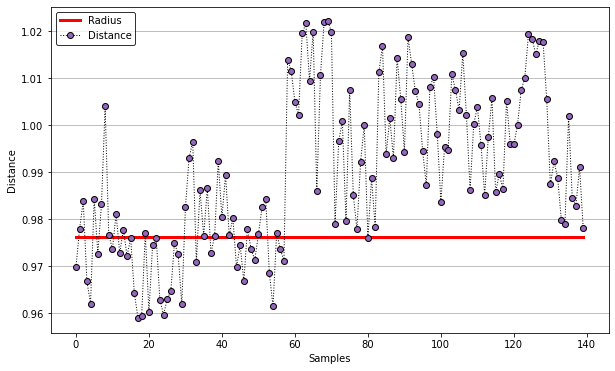

Epoch 1/10
2/2 [==============================] - 55s 33s/step - loss: 1.3245 - accuracy: 0.0983 - val_loss: 1.3316 - val_accuracy: 0.1019
Epoch 2/10
2/2 [==============================] - 39s 30s/step - loss: 1.3218 - accuracy: 0.1025 - val_loss: 1.3305 - val_accuracy: 0.1074
Epoch 3/10
2/2 [==============================] - 38s 29s/step - loss: 1.3205 - accuracy: 0.1079 - val_loss: 1.3297 - val_accuracy: 0.1140
Epoch 4/10
2/2 [==============================] - 39s 30s/step - loss: 1.3197 - accuracy: 0.1147 - val_loss: 1.3290 - val_accuracy: 0.1217
Epoch 5/10
2/2 [==============================] - 39s 29s/step - loss: 1.3191 - accuracy: 0.1237 - val_loss: 1.3285 - val_accuracy: 0.1303
Epoch 6/10
2/2 [==============================] - 39s 29s/step - loss: 1.3186 - accuracy: 0.1330 - val_loss: 1.3280 - val_accuracy: 0.1397
Epoch 7/10
2/2 [==============================] - 38s 29s/step - loss: 1.3183 - accuracy: 0.1424 - val_loss: 1.3277 - val_accuracy: 0.1496
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3621 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9734
number of samples    = 224
number of features   = 90112
number of SVs        = 134
ratio of SVs         = 59.8214 %
accuracy             = 93.3036 %




*** Prediction of the provided data is completed. ***

running time         = 0.9105 seconds
number of samples    = 82
number of alarm      = 80
accuracy             = 97.5610 %




*** Prediction of the provided data is completed. ***

running time         = 0.6375 seconds
number of samples    = 58
number of alarm      = 24
accuracy             = 58.6207 %




*** Prediction of the provided data is completed. ***

running time         = 1.4096 seconds
number of samples    = 140
number of alarm      = 104
accuracy             = 81.4286 %




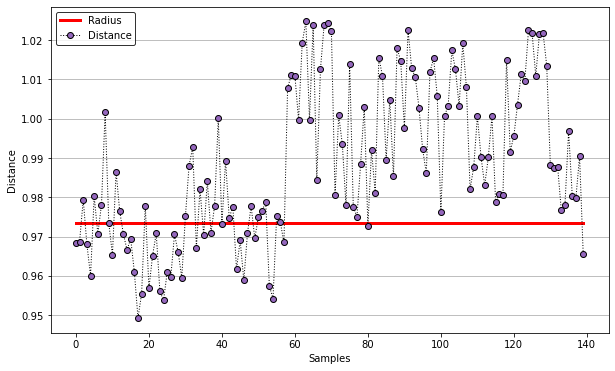

Epoch 1/10
2/2 [==============================] - 54s 32s/step - loss: 1.3416 - accuracy: 0.3088 - val_loss: 1.3283 - val_accuracy: 0.3549
Epoch 2/10
2/2 [==============================] - 40s 30s/step - loss: 1.3405 - accuracy: 0.3649 - val_loss: 1.3277 - val_accuracy: 0.4024
Epoch 3/10
2/2 [==============================] - 38s 29s/step - loss: 1.3402 - accuracy: 0.4086 - val_loss: 1.3274 - val_accuracy: 0.4413
Epoch 4/10
2/2 [==============================] - 38s 29s/step - loss: 1.3409 - accuracy: 0.4429 - val_loss: 1.3273 - val_accuracy: 0.4748
Epoch 5/10
2/2 [==============================] - 40s 30s/step - loss: 1.3436 - accuracy: 0.4743 - val_loss: 1.3275 - val_accuracy: 0.5039
Epoch 6/10
2/2 [==============================] - 39s 30s/step - loss: 1.3512 - accuracy: 0.5027 - val_loss: 1.3286 - val_accuracy: 0.5281
Epoch 7/10
2/2 [==============================] - 38s 29s/step - loss: 1.3647 - accuracy: 0.5276 - val_loss: 1.3315 - val_accuracy: 0.5470
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3140 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9833
number of samples    = 224
number of features   = 90112
number of SVs        = 158
ratio of SVs         = 70.5357 %
accuracy             = 95.5357 %




*** Prediction of the provided data is completed. ***

running time         = 0.9437 seconds
number of samples    = 82
number of alarm      = 81
accuracy             = 98.7805 %




*** Prediction of the provided data is completed. ***

running time         = 0.7161 seconds
number of samples    = 58
number of alarm      = 33
accuracy             = 43.1034 %




*** Prediction of the provided data is completed. ***

running time         = 1.3091 seconds
number of samples    = 140
number of alarm      = 114
accuracy             = 75.7143 %




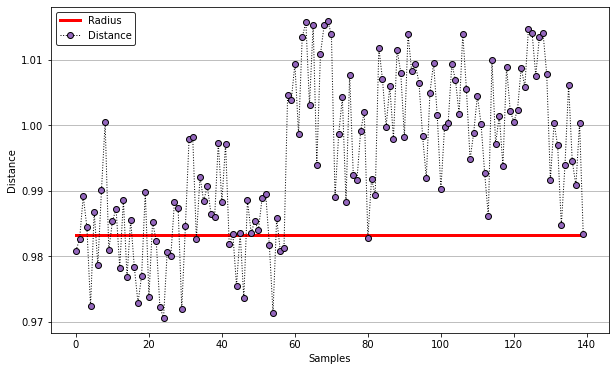

Wall time: 38min 59s


In [3]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
2/2 [==============================] - 54s 31s/step - loss: 2.2181 - accuracy: 0.2795 - val_loss: 2.2178 - val_accuracy: 0.2841
Epoch 2/10
2/2 [==============================] - 39s 29s/step - loss: 2.2178 - accuracy: 0.2805 - val_loss: 2.2182 - val_accuracy: 0.2830
Epoch 3/10
2/2 [==============================] - 38s 29s/step - loss: 2.2192 - accuracy: 0.2818 - val_loss: 2.2192 - val_accuracy: 0.2823
Epoch 4/10
2/2 [==============================] - 37s 27s/step - loss: 2.2240 - accuracy: 0.2833 - val_loss: 2.2213 - val_accuracy: 0.2821
Epoch 5/10
2/2 [==============================] - 36s 27s/step - loss: 2.2358 - accuracy: 0.2827 - val_loss: 2.2249 - val_accuracy: 0.2808
Epoch 6/10
2/2 [==============================] - 36s 27s/step - loss: 2.2672 - accuracy: 0.2829 - val_loss: 2.2310 - val_accuracy: 0.2799
Epoch 7/10
2/2 [==============================] - 36s 27s/step - loss: 2.3351 - accuracy: 0.2821 - val_loss: 2.2406 - val_accuracy: 0.2785
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2679 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9928
number of samples    = 219
number of features   = 90112
number of SVs        = 195
ratio of SVs         = 89.0411 %
accuracy             = 21.0046 %




*** Prediction of the provided data is completed. ***

running time         = 1.1121 seconds
number of samples    = 109
number of alarm      = 103
accuracy             = 94.4954 %




*** Prediction of the provided data is completed. ***

running time         = 0.2537 seconds
number of samples    = 23
number of alarm      = 20
accuracy             = 13.0435 %




*** Prediction of the provided data is completed. ***

running time         = 1.3799 seconds
number of samples    = 132
number of alarm      = 123
accuracy             = 80.3030 %




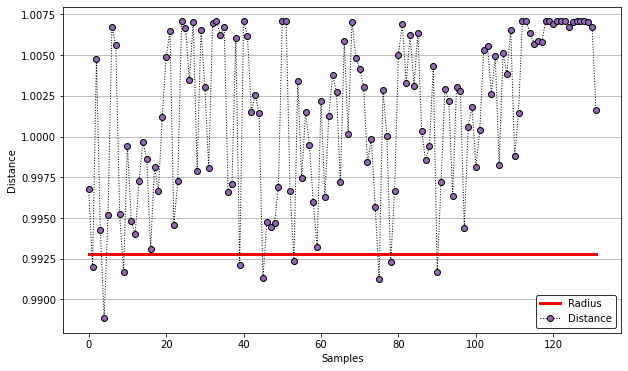

Epoch 1/10
2/2 [==============================] - 54s 31s/step - loss: 2.2272 - accuracy: 0.3204 - val_loss: 2.2157 - val_accuracy: 0.3203
Epoch 2/10
2/2 [==============================] - 40s 30s/step - loss: 2.2273 - accuracy: 0.3239 - val_loss: 2.2159 - val_accuracy: 0.3211
Epoch 3/10
2/2 [==============================] - 38s 29s/step - loss: 2.2284 - accuracy: 0.3284 - val_loss: 2.2166 - val_accuracy: 0.3224
Epoch 4/10
2/2 [==============================] - 38s 29s/step - loss: 2.2319 - accuracy: 0.3316 - val_loss: 2.2180 - val_accuracy: 0.3227
Epoch 5/10
2/2 [==============================] - 38s 29s/step - loss: 2.2432 - accuracy: 0.3318 - val_loss: 2.2208 - val_accuracy: 0.3220
Epoch 6/10
2/2 [==============================] - 38s 29s/step - loss: 2.2749 - accuracy: 0.3302 - val_loss: 2.2259 - val_accuracy: 0.3211
Epoch 7/10
2/2 [==============================] - 38s 29s/step - loss: 2.3277 - accuracy: 0.3307 - val_loss: 2.2342 - val_accuracy: 0.3201
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2651 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9916
number of samples    = 219
number of features   = 90112
number of SVs        = 160
ratio of SVs         = 73.0594 %
accuracy             = 98.6301 %




*** Prediction of the provided data is completed. ***

running time         = 1.0935 seconds
number of samples    = 109
number of alarm      = 102
accuracy             = 93.5780 %




*** Prediction of the provided data is completed. ***

running time         = 0.2656 seconds
number of samples    = 23
number of alarm      = 18
accuracy             = 21.7391 %




*** Prediction of the provided data is completed. ***

running time         = 1.3122 seconds
number of samples    = 132
number of alarm      = 120
accuracy             = 81.0606 %




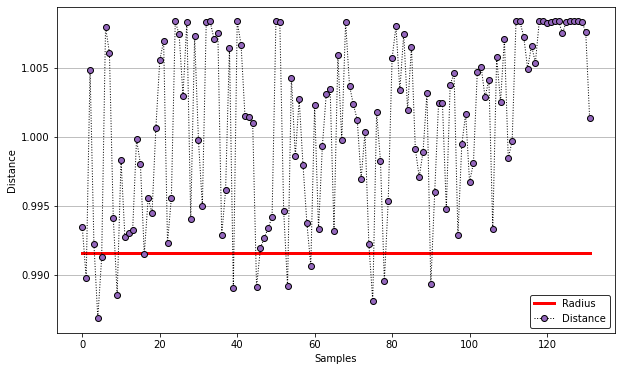

Epoch 1/10
2/2 [==============================] - 55s 33s/step - loss: 2.2029 - accuracy: 0.2761 - val_loss: 2.2187 - val_accuracy: 0.2670
Epoch 2/10
2/2 [==============================] - 39s 29s/step - loss: 2.2026 - accuracy: 0.2803 - val_loss: 2.2188 - val_accuracy: 0.2647
Epoch 3/10
2/2 [==============================] - 38s 29s/step - loss: 2.2031 - accuracy: 0.2840 - val_loss: 2.2194 - val_accuracy: 0.2633
Epoch 4/10
2/2 [==============================] - 38s 29s/step - loss: 2.2048 - accuracy: 0.2854 - val_loss: 2.2204 - val_accuracy: 0.2633
Epoch 5/10
2/2 [==============================] - 38s 29s/step - loss: 2.2099 - accuracy: 0.2864 - val_loss: 2.2223 - val_accuracy: 0.2647
Epoch 6/10
2/2 [==============================] - 38s 29s/step - loss: 2.2227 - accuracy: 0.2845 - val_loss: 2.2253 - val_accuracy: 0.2674
Epoch 7/10
2/2 [==============================] - 38s 29s/step - loss: 2.2498 - accuracy: 0.2845 - val_loss: 2.2303 - val_accuracy: 0.2705
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2651 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9943
number of samples    = 219
number of features   = 90112
number of SVs        = 196
ratio of SVs         = 89.4977 %
accuracy             = 16.4384 %




*** Prediction of the provided data is completed. ***

running time         = 1.1247 seconds
number of samples    = 109
number of alarm      = 108
accuracy             = 99.0826 %




*** Prediction of the provided data is completed. ***

running time         = 0.2500 seconds
number of samples    = 23
number of alarm      = 20
accuracy             = 13.0435 %




*** Prediction of the provided data is completed. ***

running time         = 1.2809 seconds
number of samples    = 132
number of alarm      = 128
accuracy             = 84.0909 %




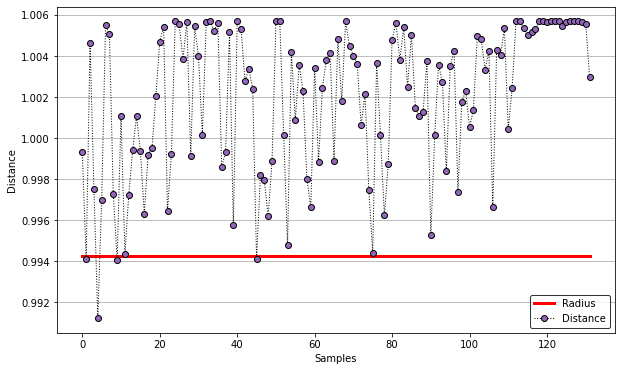

Epoch 1/10
2/2 [==============================] - 55s 32s/step - loss: 2.2415 - accuracy: 0.4536 - val_loss: 2.2123 - val_accuracy: 0.4445
Epoch 2/10
2/2 [==============================] - 39s 30s/step - loss: 2.2412 - accuracy: 0.4519 - val_loss: 2.2121 - val_accuracy: 0.4457
Epoch 3/10
2/2 [==============================] - 43s 33s/step - loss: 2.2411 - accuracy: 0.4542 - val_loss: 2.2120 - val_accuracy: 0.4479
Epoch 4/10
2/2 [==============================] - 42s 31s/step - loss: 2.2411 - accuracy: 0.4544 - val_loss: 2.2120 - val_accuracy: 0.4511
Epoch 5/10
2/2 [==============================] - 39s 30s/step - loss: 2.2413 - accuracy: 0.4574 - val_loss: 2.2119 - val_accuracy: 0.4531
Epoch 6/10
2/2 [==============================] - 39s 30s/step - loss: 2.2418 - accuracy: 0.4555 - val_loss: 2.2120 - val_accuracy: 0.4529
Epoch 7/10
2/2 [==============================] - 40s 30s/step - loss: 2.2426 - accuracy: 0.4517 - val_loss: 2.2121 - val_accuracy: 0.4499
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3898 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9959
number of samples    = 219
number of features   = 90112
number of SVs        = 210
ratio of SVs         = 95.8904 %
accuracy             = 8.6758 %




*** Prediction of the provided data is completed. ***

running time         = 1.0858 seconds
number of samples    = 109
number of alarm      = 109
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.2558 seconds
number of samples    = 23
number of alarm      = 22
accuracy             = 4.3478 %




*** Prediction of the provided data is completed. ***

running time         = 1.3115 seconds
number of samples    = 132
number of alarm      = 131
accuracy             = 83.3333 %




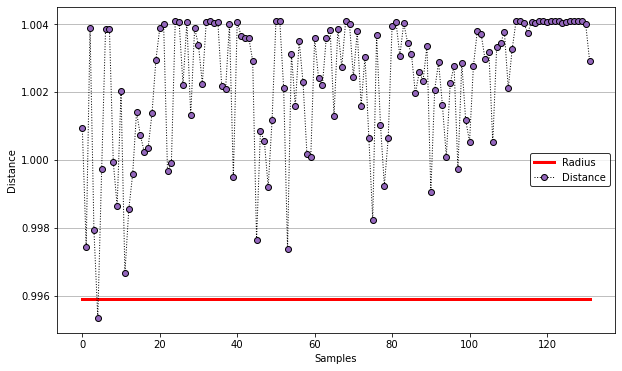

Epoch 1/10
2/2 [==============================] - 53s 31s/step - loss: 2.2194 - accuracy: 0.2803 - val_loss: 2.2179 - val_accuracy: 0.2814
Epoch 2/10
2/2 [==============================] - 38s 29s/step - loss: 2.2196 - accuracy: 0.2954 - val_loss: 2.2184 - val_accuracy: 0.2914
Epoch 3/10
2/2 [==============================] - 39s 29s/step - loss: 2.2221 - accuracy: 0.3065 - val_loss: 2.2197 - val_accuracy: 0.3018
Epoch 4/10
2/2 [==============================] - 38s 29s/step - loss: 2.2296 - accuracy: 0.3168 - val_loss: 2.2223 - val_accuracy: 0.3110
Epoch 5/10
2/2 [==============================] - 38s 29s/step - loss: 2.2523 - accuracy: 0.3243 - val_loss: 2.2273 - val_accuracy: 0.3187
Epoch 6/10
2/2 [==============================] - 38s 29s/step - loss: 2.3076 - accuracy: 0.3290 - val_loss: 2.2358 - val_accuracy: 0.3252
Epoch 7/10
2/2 [==============================] - 38s 28s/step - loss: 2.4039 - accuracy: 0.3336 - val_loss: 2.2490 - val_accuracy: 0.3300
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.3024 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9920
number of samples    = 219
number of features   = 90112
number of SVs        = 166
ratio of SVs         = 75.7991 %
accuracy             = 28.3105 %




*** Prediction of the provided data is completed. ***

running time         = 1.1152 seconds
number of samples    = 109
number of alarm      = 102
accuracy             = 93.5780 %




*** Prediction of the provided data is completed. ***

running time         = 0.2668 seconds
number of samples    = 23
number of alarm      = 17
accuracy             = 26.0870 %




*** Prediction of the provided data is completed. ***

running time         = 1.2885 seconds
number of samples    = 132
number of alarm      = 119
accuracy             = 81.8182 %




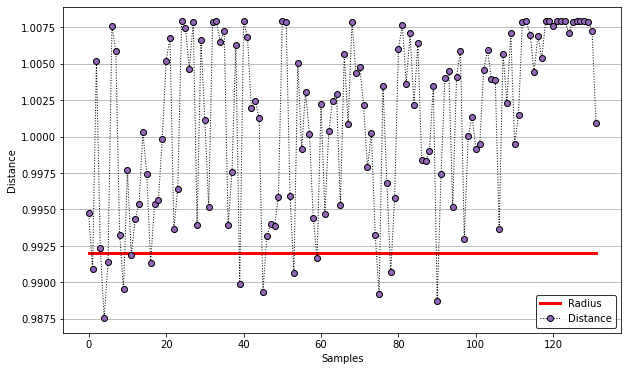

Wall time: 41min 46s


In [4]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam',loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-3), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
2/2 [==============================] - 67s 43s/step - loss: 1.1781 - accuracy: 0.4441 - val_loss: 1.1762 - val_accuracy: 0.4488
Epoch 2/10
2/2 [==============================] - 51s 41s/step - loss: 1.1778 - accuracy: 0.4497 - val_loss: 1.1761 - val_accuracy: 0.4546
Epoch 3/10
2/2 [==============================] - 50s 40s/step - loss: 1.1776 - accuracy: 0.4558 - val_loss: 1.1761 - val_accuracy: 0.4609
Epoch 4/10
2/2 [==============================] - 49s 40s/step - loss: 1.1776 - accuracy: 0.4616 - val_loss: 1.1760 - val_accuracy: 0.4674
Epoch 5/10
2/2 [==============================] - 49s 40s/step - loss: 1.1776 - accuracy: 0.4666 - val_loss: 1.1760 - val_accuracy: 0.4735
Epoch 6/10
2/2 [==============================] - 50s 41s/step - loss: 1.1775 - accuracy: 0.4733 - val_loss: 1.1760 - val_accuracy: 0.4792
Epoch 7/10
2/2 [==============================] - 49s 40s/step - loss: 1.1775 - accuracy: 0.4781 - val_loss: 1.1760 - val_accuracy: 0.4847
Epoch 8/10
2/2 [===========

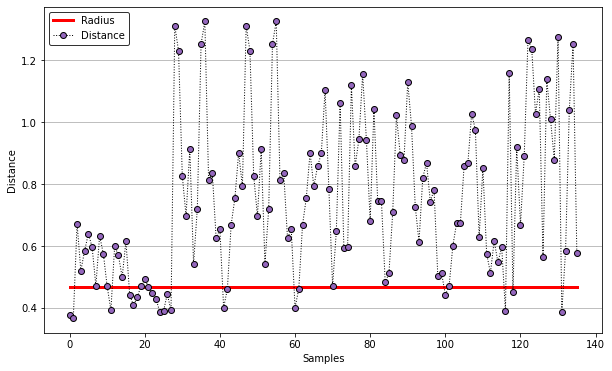

Epoch 1/10
2/2 [==============================] - 67s 43s/step - loss: 1.1816 - accuracy: 0.4052 - val_loss: 1.1761 - val_accuracy: 0.4147
Epoch 2/10
2/2 [==============================] - 51s 41s/step - loss: 1.1809 - accuracy: 0.4114 - val_loss: 1.1760 - val_accuracy: 0.4215
Epoch 3/10
2/2 [==============================] - 49s 40s/step - loss: 1.1807 - accuracy: 0.4180 - val_loss: 1.1760 - val_accuracy: 0.4272
Epoch 4/10
2/2 [==============================] - 49s 40s/step - loss: 1.1806 - accuracy: 0.4254 - val_loss: 1.1760 - val_accuracy: 0.4331
Epoch 5/10
2/2 [==============================] - 50s 40s/step - loss: 1.1806 - accuracy: 0.4331 - val_loss: 1.1760 - val_accuracy: 0.4386
Epoch 6/10
2/2 [==============================] - 50s 41s/step - loss: 1.1806 - accuracy: 0.4414 - val_loss: 1.1761 - val_accuracy: 0.4430
Epoch 7/10
2/2 [==============================] - 49s 40s/step - loss: 1.1807 - accuracy: 0.4476 - val_loss: 1.1762 - val_accuracy: 0.4469
Epoch 8/10
2/2 [===========

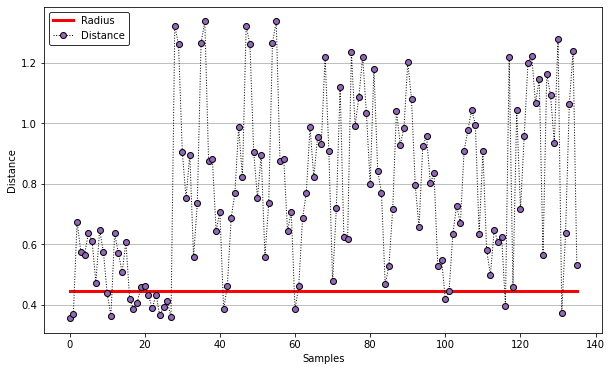

Epoch 1/10
2/2 [==============================] - 67s 43s/step - loss: 1.1775 - accuracy: 0.2542 - val_loss: 1.1768 - val_accuracy: 0.2504
Epoch 2/10
2/2 [==============================] - 49s 40s/step - loss: 1.1770 - accuracy: 0.2680 - val_loss: 1.1767 - val_accuracy: 0.2622
Epoch 3/10
2/2 [==============================] - 49s 40s/step - loss: 1.1768 - accuracy: 0.2834 - val_loss: 1.1767 - val_accuracy: 0.2756
Epoch 4/10
2/2 [==============================] - 49s 40s/step - loss: 1.1768 - accuracy: 0.3002 - val_loss: 1.1767 - val_accuracy: 0.2895
Epoch 5/10
2/2 [==============================] - 49s 40s/step - loss: 1.1768 - accuracy: 0.3163 - val_loss: 1.1769 - val_accuracy: 0.3031
Epoch 6/10
2/2 [==============================] - 49s 40s/step - loss: 1.1771 - accuracy: 0.3302 - val_loss: 1.1771 - val_accuracy: 0.3154
Epoch 7/10
2/2 [==============================] - 49s 40s/step - loss: 1.1779 - accuracy: 0.3386 - val_loss: 1.1777 - val_accuracy: 0.3280
Epoch 8/10
2/2 [===========

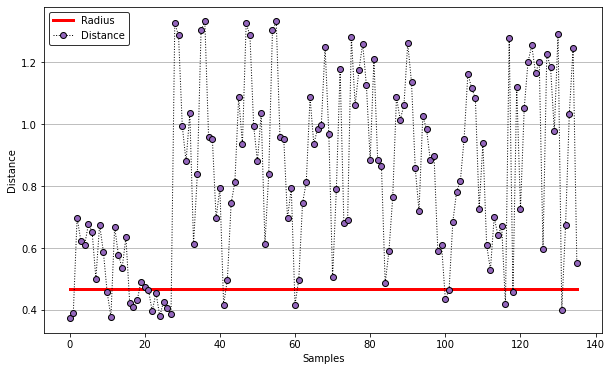

Epoch 1/10
2/2 [==============================] - 66s 43s/step - loss: 1.1824 - accuracy: 0.2565 - val_loss: 1.1761 - val_accuracy: 0.2755
Epoch 2/10
2/2 [==============================] - 50s 40s/step - loss: 1.1822 - accuracy: 0.2893 - val_loss: 1.1761 - val_accuracy: 0.3055
Epoch 3/10
2/2 [==============================] - 49s 40s/step - loss: 1.1821 - accuracy: 0.3261 - val_loss: 1.1761 - val_accuracy: 0.3332
Epoch 4/10
2/2 [==============================] - 51s 41s/step - loss: 1.1821 - accuracy: 0.3591 - val_loss: 1.1762 - val_accuracy: 0.3572
Epoch 5/10
2/2 [==============================] - 49s 40s/step - loss: 1.1824 - accuracy: 0.3869 - val_loss: 1.1766 - val_accuracy: 0.3769
Epoch 6/10
2/2 [==============================] - 50s 40s/step - loss: 1.1835 - accuracy: 0.4081 - val_loss: 1.1773 - val_accuracy: 0.3940
Epoch 7/10
2/2 [==============================] - 50s 40s/step - loss: 1.1856 - accuracy: 0.4197 - val_loss: 1.1784 - val_accuracy: 0.4040
Epoch 8/10
2/2 [===========

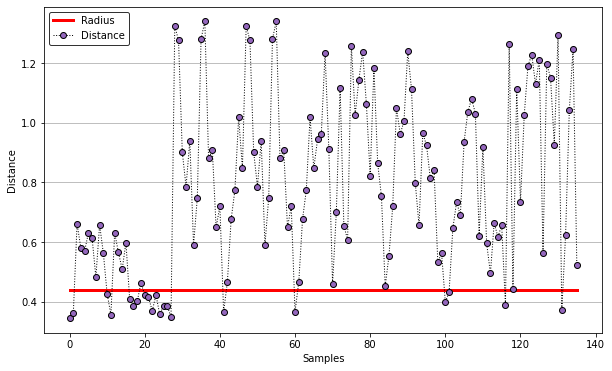

Epoch 1/10
2/2 [==============================] - 72s 46s/step - loss: 1.1798 - accuracy: 0.2551 - val_loss: 1.1764 - val_accuracy: 0.2607
Epoch 2/10
2/2 [==============================] - 53s 42s/step - loss: 1.1794 - accuracy: 0.2629 - val_loss: 1.1763 - val_accuracy: 0.2682
Epoch 3/10
2/2 [==============================] - 51s 41s/step - loss: 1.1792 - accuracy: 0.2731 - val_loss: 1.1762 - val_accuracy: 0.2761
Epoch 4/10
2/2 [==============================] - 50s 41s/step - loss: 1.1791 - accuracy: 0.2797 - val_loss: 1.1762 - val_accuracy: 0.2835
Epoch 5/10
2/2 [==============================] - 51s 41s/step - loss: 1.1791 - accuracy: 0.2890 - val_loss: 1.1762 - val_accuracy: 0.2895
Epoch 6/10
2/2 [==============================] - 50s 41s/step - loss: 1.1790 - accuracy: 0.2965 - val_loss: 1.1762 - val_accuracy: 0.2943
Epoch 7/10
2/2 [==============================] - 50s 41s/step - loss: 1.1790 - accuracy: 0.3042 - val_loss: 1.1763 - val_accuracy: 0.2981
Epoch 8/10
2/2 [===========

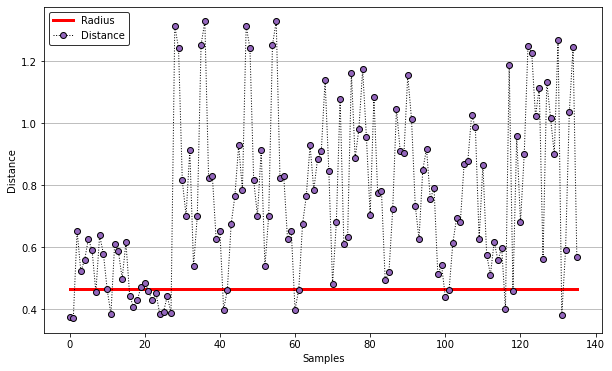

Wall time: 49min 6s


In [5]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))
    svdd = BaseSVDD(C=2**(-7), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/4
15/15 [==============================] - 156s 9s/step - loss: 1.4814 - accuracy: 0.6137 - val_loss: 1.5114 - val_accuracy: 0.6765
Epoch 2/4
15/15 [==============================] - 124s 8s/step - loss: 1.6493 - accuracy: 0.6530 - val_loss: 1.5705 - val_accuracy: 0.4692
Epoch 3/4
15/15 [==============================] - 117s 8s/step - loss: 2.7355 - accuracy: 0.4082 - val_loss: 1.7175 - val_accuracy: 0.4076
Epoch 4/4
15/15 [==============================] - 113s 8s/step - loss: 7.4671 - accuracy: 0.3755 - val_loss: 2.4248 - val_accuracy: 0.3569


*** Fitting of the SVDD model is completed. ***

running time         = 2.6110 seconds
kernel function      = rbf
iterations           = 11
radius               = 0.8395
number of samples    = 264
number of features   = 90112
number of SVs        = 26
ratio of SVs         = 9.8485 %
accuracy             = 98.4848 %




*** Prediction of the provided data is completed. ***

running time         = 0.7001 seconds
number of samples    = 5

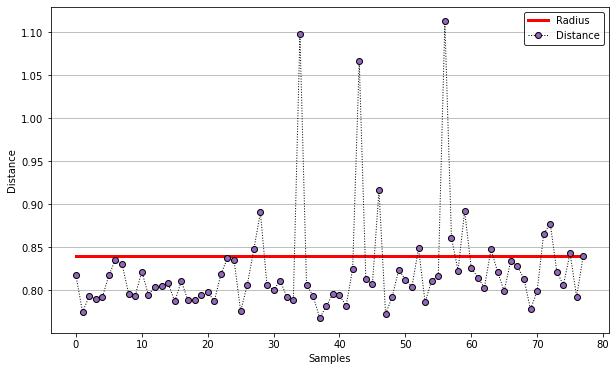

Epoch 1/4
15/15 [==============================] - 156s 8s/step - loss: 1.4805 - accuracy: 0.8310 - val_loss: 1.4595 - val_accuracy: 0.7543
Epoch 2/4
15/15 [==============================] - 120s 8s/step - loss: 1.5248 - accuracy: 0.6550 - val_loss: 1.5380 - val_accuracy: 0.5168
Epoch 3/4
15/15 [==============================] - 109s 7s/step - loss: 1.9408 - accuracy: 0.3991 - val_loss: 2.0293 - val_accuracy: 0.3774
Epoch 4/4
 5/15 [=========>....................] - ETA: 1:18 - loss: 2.7387 - accuracy: 0.3780

KeyboardInterrupt: 

In [5]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.1)
    x_train = np.array(x_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=4,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-4), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/5
13/13 [==============================] - 130s 9s/step - loss: 0.6414 - accuracy: 0.3854 - val_loss: 0.6390 - val_accuracy: 0.3921
Epoch 2/5
13/13 [==============================] - 111s 8s/step - loss: 0.6364 - accuracy: 0.3861 - val_loss: 0.6377 - val_accuracy: 0.3793
Epoch 3/5
13/13 [==============================] - 104s 8s/step - loss: 0.6355 - accuracy: 0.3811 - val_loss: 0.6408 - val_accuracy: 0.3773
Epoch 4/5
13/13 [==============================] - 105s 8s/step - loss: 0.6610 - accuracy: 0.3791 - val_loss: 0.6819 - val_accuracy: 0.3829
Epoch 5/5
13/13 [==============================] - 107s 8s/step - loss: 0.8368 - accuracy: 0.3857 - val_loss: 1.1064 - val_accuracy: 0.3913


*** Fitting of the SVDD model is completed. ***

running time         = 4.0612 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9069
number of samples    = 391
number of features   = 90112
number of SVs        = 79
ratio of SVs         = 20.2046 %
accuracy      

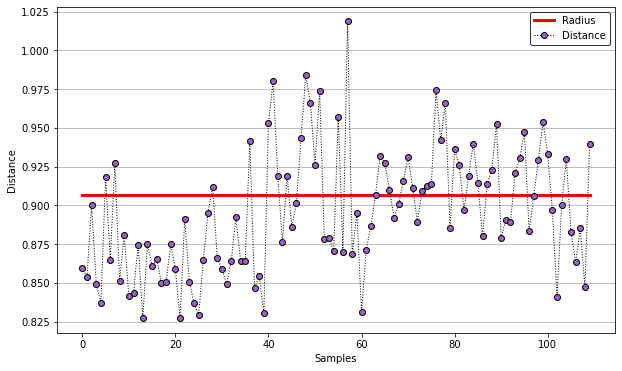

Epoch 1/5
13/13 [==============================] - 148s 9s/step - loss: 0.6406 - accuracy: 0.4432 - val_loss: 0.6401 - val_accuracy: 0.4195
Epoch 2/5


In [ ]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.5)

    x_train = np.array(x_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=5,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-6), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
2/2 [==============================] - 60s 38s/step - loss: 0.9452 - accuracy: 0.3630 - val_loss: 0.9618 - val_accuracy: 0.4637
Epoch 2/10
2/2 [==============================] - 45s 35s/step - loss: 0.9428 - accuracy: 0.5412 - val_loss: 0.9607 - val_accuracy: 0.6409
Epoch 3/10
2/2 [==============================] - 43s 34s/step - loss: 0.9404 - accuracy: 0.7068 - val_loss: 0.9599 - val_accuracy: 0.7833
Epoch 4/10
2/2 [==============================] - 44s 34s/step - loss: 0.9379 - accuracy: 0.8274 - val_loss: 0.9595 - val_accuracy: 0.8714
Epoch 5/10
2/2 [==============================] - 45s 35s/step - loss: 0.9359 - accuracy: 0.8974 - val_loss: 0.9597 - val_accuracy: 0.9166
Epoch 6/10
2/2 [==============================] - 43s 34s/step - loss: 0.9348 - accuracy: 0.9318 - val_loss: 0.9601 - val_accuracy: 0.9385
Epoch 7/10
2/2 [==============================] - 43s 34s/step - loss: 0.9346 - accuracy: 0.9454 - val_loss: 0.9599 - val_accuracy: 0.9471
Epoch 8/10
2/2 [===========

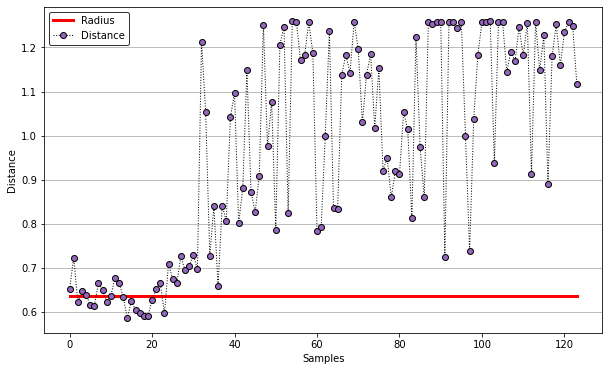

Epoch 1/10
2/2 [==============================] - 58s 37s/step - loss: 0.9659 - accuracy: 0.1552 - val_loss: 0.9616 - val_accuracy: 0.2389
Epoch 2/10
2/2 [==============================] - 44s 34s/step - loss: 0.9639 - accuracy: 0.2643 - val_loss: 0.9607 - val_accuracy: 0.3462
Epoch 3/10
2/2 [==============================] - 44s 34s/step - loss: 0.9624 - accuracy: 0.4032 - val_loss: 0.9597 - val_accuracy: 0.4686
Epoch 4/10
2/2 [==============================] - 44s 34s/step - loss: 0.9611 - accuracy: 0.5486 - val_loss: 0.9586 - val_accuracy: 0.5943
Epoch 5/10
2/2 [==============================] - 44s 34s/step - loss: 0.9598 - accuracy: 0.6775 - val_loss: 0.9575 - val_accuracy: 0.7156
Epoch 6/10
2/2 [==============================] - 43s 34s/step - loss: 0.9584 - accuracy: 0.7808 - val_loss: 0.9563 - val_accuracy: 0.8180
Epoch 7/10
2/2 [==============================] - 43s 34s/step - loss: 0.9567 - accuracy: 0.8571 - val_loss: 0.9553 - val_accuracy: 0.8950
Epoch 8/10
2/2 [===========

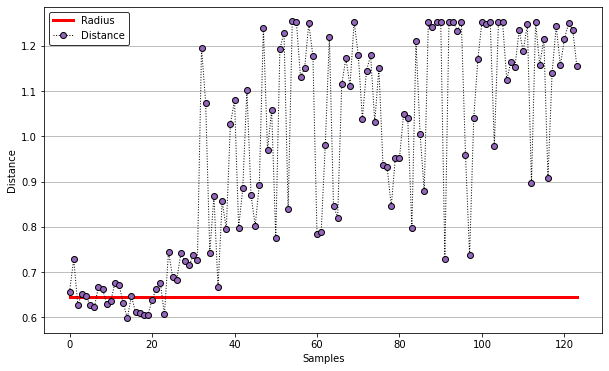

Epoch 1/10
2/2 [==============================] - 58s 36s/step - loss: 0.9663 - accuracy: 0.0163 - val_loss: 0.9654 - val_accuracy: 0.0194
Epoch 2/10
2/2 [==============================] - 46s 36s/step - loss: 0.9627 - accuracy: 0.0483 - val_loss: 0.9645 - val_accuracy: 0.0495
Epoch 3/10
2/2 [==============================] - 43s 34s/step - loss: 0.9607 - accuracy: 0.1070 - val_loss: 0.9635 - val_accuracy: 0.1056
Epoch 4/10
2/2 [==============================] - 43s 34s/step - loss: 0.9594 - accuracy: 0.1882 - val_loss: 0.9624 - val_accuracy: 0.1905
Epoch 5/10
2/2 [==============================] - 43s 34s/step - loss: 0.9583 - accuracy: 0.2821 - val_loss: 0.9612 - val_accuracy: 0.2950
Epoch 6/10
2/2 [==============================] - 43s 34s/step - loss: 0.9574 - accuracy: 0.3832 - val_loss: 0.9601 - val_accuracy: 0.4063
Epoch 7/10
2/2 [==============================] - 43s 34s/step - loss: 0.9564 - accuracy: 0.4879 - val_loss: 0.9590 - val_accuracy: 0.5182
Epoch 8/10
2/2 [===========

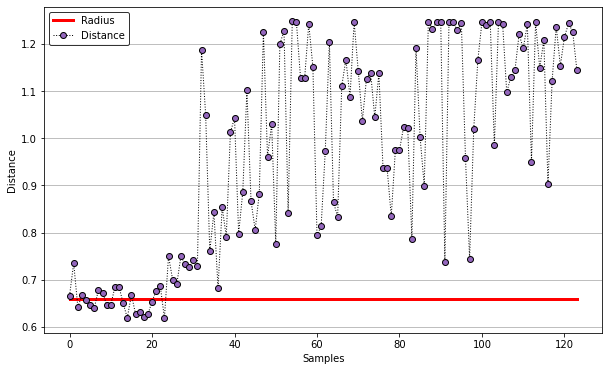

Epoch 1/10
2/2 [==============================] - 59s 36s/step - loss: 0.9626 - accuracy: 0.2253 - val_loss: 0.9616 - val_accuracy: 0.2920
Epoch 2/10
2/2 [==============================] - 42s 33s/step - loss: 0.9600 - accuracy: 0.3516 - val_loss: 0.9604 - val_accuracy: 0.4211
Epoch 3/10
2/2 [==============================] - 42s 33s/step - loss: 0.9579 - accuracy: 0.5048 - val_loss: 0.9591 - val_accuracy: 0.5615
Epoch 4/10
2/2 [==============================] - 43s 33s/step - loss: 0.9558 - accuracy: 0.6512 - val_loss: 0.9581 - val_accuracy: 0.7081
Epoch 5/10
2/2 [==============================] - 43s 34s/step - loss: 0.9539 - accuracy: 0.7739 - val_loss: 0.9576 - val_accuracy: 0.8238
Epoch 6/10
2/2 [==============================] - 42s 33s/step - loss: 0.9543 - accuracy: 0.8563 - val_loss: 0.9574 - val_accuracy: 0.8901
Epoch 7/10
2/2 [==============================] - 45s 35s/step - loss: 0.9562 - accuracy: 0.8991 - val_loss: 0.9566 - val_accuracy: 0.9199
Epoch 8/10
2/2 [===========

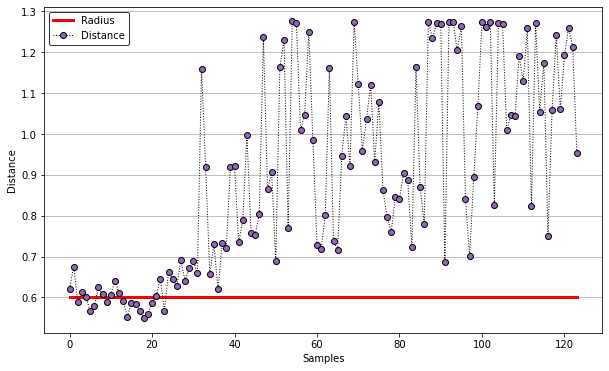

Epoch 1/10
2/2 [==============================] - 59s 37s/step - loss: 0.9496 - accuracy: 0.5024 - val_loss: 0.9605 - val_accuracy: 0.5991
Epoch 2/10
2/2 [==============================] - 44s 34s/step - loss: 0.9483 - accuracy: 0.6444 - val_loss: 0.9599 - val_accuracy: 0.7177
Epoch 3/10
2/2 [==============================] - 44s 34s/step - loss: 0.9468 - accuracy: 0.7620 - val_loss: 0.9592 - val_accuracy: 0.8194
Epoch 4/10
2/2 [==============================] - 44s 34s/step - loss: 0.9450 - accuracy: 0.8462 - val_loss: 0.9585 - val_accuracy: 0.8899
Epoch 5/10
2/2 [==============================] - 43s 34s/step - loss: 0.9431 - accuracy: 0.9021 - val_loss: 0.9582 - val_accuracy: 0.9297
Epoch 6/10
2/2 [==============================] - 43s 34s/step - loss: 0.9423 - accuracy: 0.9350 - val_loss: 0.9583 - val_accuracy: 0.9472
Epoch 7/10
2/2 [==============================] - 43s 34s/step - loss: 0.9422 - accuracy: 0.9530 - val_loss: 0.9584 - val_accuracy: 0.9536
Epoch 8/10
2/2 [===========

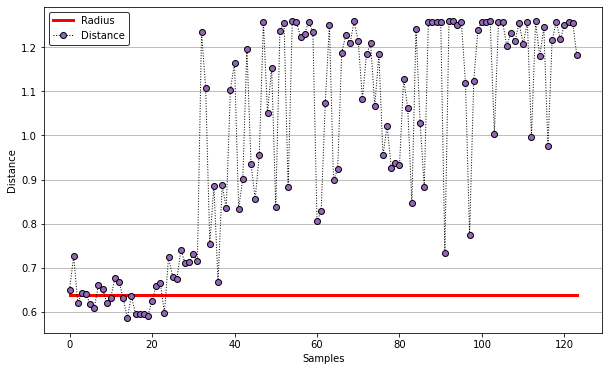

Wall time: 42min 55s


In [8]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
2/2 [==============================] - 54s 33s/step - loss: 0.7462 - accuracy: 0.3558 - val_loss: 0.7578 - val_accuracy: 0.3417
Epoch 2/10
2/2 [==============================] - 40s 30s/step - loss: 0.7458 - accuracy: 0.3517 - val_loss: 0.7578 - val_accuracy: 0.3364
Epoch 3/10
2/2 [==============================] - 40s 30s/step - loss: 0.7458 - accuracy: 0.3478 - val_loss: 0.7579 - val_accuracy: 0.3309
Epoch 4/10
2/2 [==============================] - 39s 30s/step - loss: 0.7462 - accuracy: 0.3430 - val_loss: 0.7582 - val_accuracy: 0.3248
Epoch 5/10
2/2 [==============================] - 41s 31s/step - loss: 0.7471 - accuracy: 0.3337 - val_loss: 0.7588 - val_accuracy: 0.3178
Epoch 6/10
2/2 [==============================] - 40s 30s/step - loss: 0.7489 - accuracy: 0.3260 - val_loss: 0.7598 - val_accuracy: 0.3104
Epoch 7/10
2/2 [==============================] - 39s 30s/step - loss: 0.7525 - accuracy: 0.3167 - val_loss: 0.7614 - val_accuracy: 0.3030
Epoch 8/10
2/2 [===========

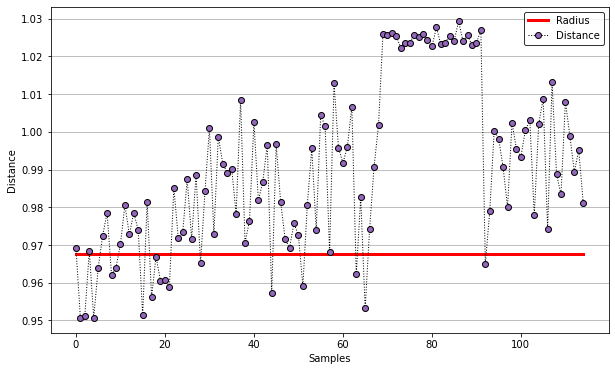

Epoch 1/10
2/2 [==============================] - 54s 33s/step - loss: 0.7526 - accuracy: 0.3696 - val_loss: 0.7566 - val_accuracy: 0.3827
Epoch 2/10
2/2 [==============================] - 40s 30s/step - loss: 0.7523 - accuracy: 0.3779 - val_loss: 0.7566 - val_accuracy: 0.3896
Epoch 3/10
2/2 [==============================] - 40s 30s/step - loss: 0.7523 - accuracy: 0.3867 - val_loss: 0.7566 - val_accuracy: 0.3939
Epoch 4/10
2/2 [==============================] - 40s 30s/step - loss: 0.7527 - accuracy: 0.3917 - val_loss: 0.7569 - val_accuracy: 0.3969
Epoch 5/10
2/2 [==============================] - 40s 30s/step - loss: 0.7535 - accuracy: 0.3962 - val_loss: 0.7574 - val_accuracy: 0.4001
Epoch 6/10
2/2 [==============================] - 40s 30s/step - loss: 0.7553 - accuracy: 0.3997 - val_loss: 0.7582 - val_accuracy: 0.4033
Epoch 7/10
2/2 [==============================] - 40s 30s/step - loss: 0.7587 - accuracy: 0.4033 - val_loss: 0.7594 - val_accuracy: 0.4057
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2637 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9626
number of samples    = 220
number of features   = 90112
number of SVs        = 119
ratio of SVs         = 54.0909 %
accuracy             = 53.6364 %




*** Prediction of the provided data is completed. ***

running time         = 1.0466 seconds
number of samples    = 93
number of alarm      = 88
accuracy             = 94.6237 %




*** Prediction of the provided data is completed. ***

running time         = 0.2499 seconds
number of samples    = 22
number of alarm      = 8
accuracy             = 63.6364 %




*** Prediction of the provided data is completed. ***

running time         = 1.1873 seconds
number of samples    = 115
number of alarm      = 96
accuracy             = 88.6957 %




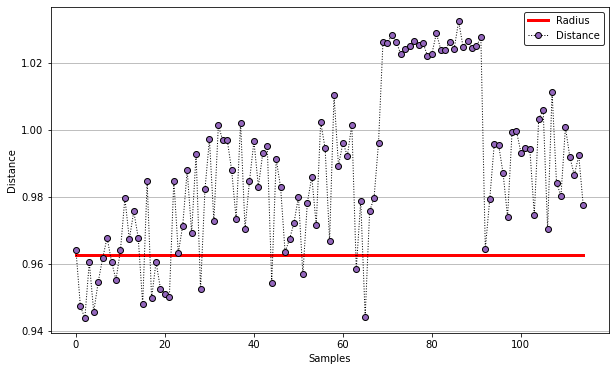

Epoch 1/10
2/2 [==============================] - 54s 32s/step - loss: 0.7632 - accuracy: 0.4240 - val_loss: 0.7551 - val_accuracy: 0.4340
Epoch 2/10
2/2 [==============================] - 39s 30s/step - loss: 0.7630 - accuracy: 0.4330 - val_loss: 0.7550 - val_accuracy: 0.4374
Epoch 3/10
2/2 [==============================] - 40s 30s/step - loss: 0.7630 - accuracy: 0.4395 - val_loss: 0.7550 - val_accuracy: 0.4386
Epoch 4/10
2/2 [==============================] - 40s 30s/step - loss: 0.7630 - accuracy: 0.4419 - val_loss: 0.7551 - val_accuracy: 0.4383
Epoch 5/10
2/2 [==============================] - 39s 30s/step - loss: 0.7631 - accuracy: 0.4450 - val_loss: 0.7551 - val_accuracy: 0.4368
Epoch 6/10
2/2 [==============================] - 40s 30s/step - loss: 0.7634 - accuracy: 0.4460 - val_loss: 0.7553 - val_accuracy: 0.4350
Epoch 7/10
2/2 [==============================] - 39s 30s/step - loss: 0.7640 - accuracy: 0.4452 - val_loss: 0.7557 - val_accuracy: 0.4328
Epoch 8/10
2/2 [===========

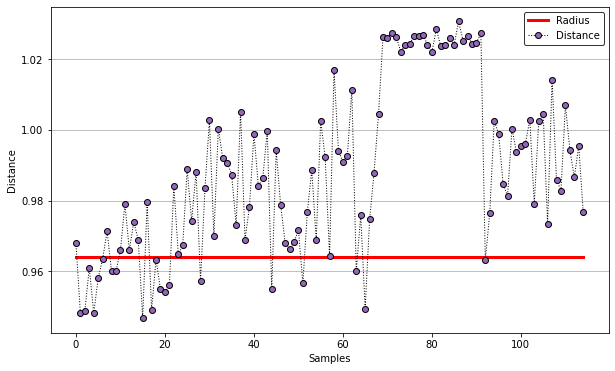

Epoch 1/10
2/2 [==============================] - 55s 33s/step - loss: 0.7358 - accuracy: 0.2377 - val_loss: 0.7587 - val_accuracy: 0.2615
Epoch 2/10
2/2 [==============================] - 40s 30s/step - loss: 0.7355 - accuracy: 0.2487 - val_loss: 0.7587 - val_accuracy: 0.2716
Epoch 3/10
2/2 [==============================] - 40s 31s/step - loss: 0.7355 - accuracy: 0.2598 - val_loss: 0.7587 - val_accuracy: 0.2782
Epoch 4/10
2/2 [==============================] - 40s 30s/step - loss: 0.7356 - accuracy: 0.2677 - val_loss: 0.7588 - val_accuracy: 0.2830
Epoch 5/10
2/2 [==============================] - 39s 30s/step - loss: 0.7360 - accuracy: 0.2736 - val_loss: 0.7591 - val_accuracy: 0.2869
Epoch 6/10
2/2 [==============================] - 39s 30s/step - loss: 0.7370 - accuracy: 0.2773 - val_loss: 0.7597 - val_accuracy: 0.2895
Epoch 7/10
2/2 [==============================] - 39s 30s/step - loss: 0.7391 - accuracy: 0.2817 - val_loss: 0.7608 - val_accuracy: 0.2903
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.1714 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9660
number of samples    = 220
number of features   = 90112
number of SVs        = 121
ratio of SVs         = 55.0000 %
accuracy             = 53.1818 %




*** Prediction of the provided data is completed. ***

running time         = 1.0154 seconds
number of samples    = 93
number of alarm      = 87
accuracy             = 93.5484 %




*** Prediction of the provided data is completed. ***

running time         = 0.2499 seconds
number of samples    = 22
number of alarm      = 9
accuracy             = 59.0909 %




*** Prediction of the provided data is completed. ***

running time         = 1.2028 seconds
number of samples    = 115
number of alarm      = 96
accuracy             = 86.9565 %




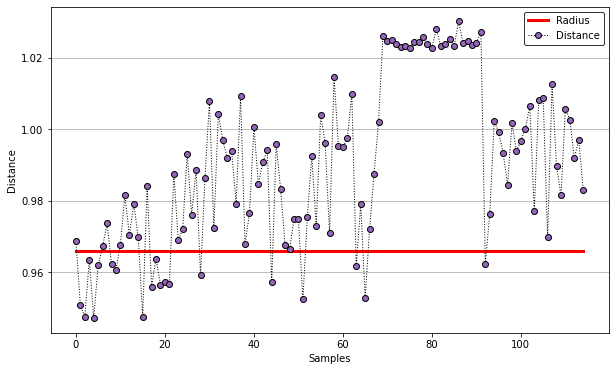

Epoch 1/10
2/2 [==============================] - 54s 32s/step - loss: 0.7681 - accuracy: 0.4679 - val_loss: 0.7547 - val_accuracy: 0.4887
Epoch 2/10
2/2 [==============================] - 39s 30s/step - loss: 0.7676 - accuracy: 0.4863 - val_loss: 0.7546 - val_accuracy: 0.5073
Epoch 3/10
2/2 [==============================] - 40s 30s/step - loss: 0.7675 - accuracy: 0.5038 - val_loss: 0.7545 - val_accuracy: 0.5246
Epoch 4/10
2/2 [==============================] - 41s 30s/step - loss: 0.7674 - accuracy: 0.5232 - val_loss: 0.7544 - val_accuracy: 0.5400
Epoch 5/10
2/2 [==============================] - 39s 30s/step - loss: 0.7673 - accuracy: 0.5372 - val_loss: 0.7544 - val_accuracy: 0.5528
Epoch 6/10
2/2 [==============================] - 40s 30s/step - loss: 0.7673 - accuracy: 0.5478 - val_loss: 0.7544 - val_accuracy: 0.5627
Epoch 7/10
2/2 [==============================] - 41s 31s/step - loss: 0.7675 - accuracy: 0.5577 - val_loss: 0.7546 - val_accuracy: 0.5700
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.2182 seconds
kernel function      = rbf
iterations           = 9
radius               = 0.9679
number of samples    = 220
number of features   = 90112
number of SVs        = 113
ratio of SVs         = 51.3636 %
accuracy             = 54.0909 %




*** Prediction of the provided data is completed. ***

running time         = 1.0310 seconds
number of samples    = 93
number of alarm      = 86
accuracy             = 92.4731 %




*** Prediction of the provided data is completed. ***

running time         = 0.2616 seconds
number of samples    = 22
number of alarm      = 10
accuracy             = 54.5455 %




*** Prediction of the provided data is completed. ***

running time         = 1.1872 seconds
number of samples    = 115
number of alarm      = 96
accuracy             = 85.2174 %




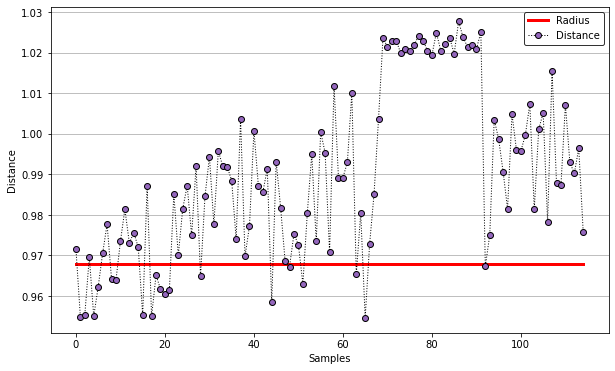

Wall time: 38min 58s


In [9]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/3
15/15 [==============================] - 129s 7s/step - loss: 1.0293 - accuracy: 0.5341 - val_loss: 1.0310 - val_accuracy: 0.5436
Epoch 2/3
15/15 [==============================] - 108s 7s/step - loss: 1.4592 - accuracy: 0.5100 - val_loss: 1.9883 - val_accuracy: 0.4738
Epoch 3/3
15/15 [==============================] - 121s 8s/step - loss: 3.9229 - accuracy: 0.4911 - val_loss: 8.9113 - val_accuracy: 0.4839


C:\Users\Shuta Tsuchio\M_learning\deep_svdd.py:269: RuntimeWarning: invalid value encountered in sqrt
  self.radius = np.sqrt(np.mean(np.diag(K)) + self.offset+np.mean(tmp_[self.boundary_indices, 0]))




*** Fitting of the SVDD model is completed. ***

running time         = 0.9640 seconds
kernel function      = poly
iterations           = 11
radius               = nan
number of samples    = 267
number of features   = 90112
number of SVs        = 7
ratio of SVs         = 2.6217 %
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.2824 seconds
number of samples    = 141
number of alarm      = 0
accuracy             = 0.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.1128 seconds
number of samples    = 26
number of alarm      = 0
accuracy             = 100.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.3136 seconds
number of samples    = 167
number of alarm      = 0
accuracy             = 15.5689 %




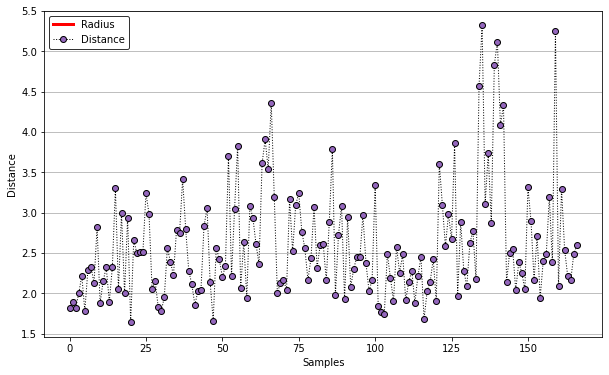

KeyboardInterrupt: 

In [2]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.1)
    x_train = np.array(x_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=3,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), degree=5, kernel='poly', coef0=1, display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [ ]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.1)

    x_train = np.array(x_train, dtype='float32')
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=4,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-0), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/4
18/18 [==============================] - 221s 10s/step - loss: 2.4910 - accuracy: 0.3678 - val_loss: 2.5478 - val_accuracy: 0.3821
Epoch 2/4
18/18 [==============================] - 163s 9s/step - loss: 5.3908 - accuracy: 0.3995 - val_loss: 3.7226 - val_accuracy: 0.4229
Epoch 3/4
18/18 [==============================] - 168s 9s/step - loss: 19.7876 - accuracy: 0.4071 - val_loss: 6.4928 - val_accuracy: 0.4031
Epoch 4/4
15/18 [========================>.....] - ETA: 27s - loss: 65.4136 - accuracy: 0.4158

Epoch 1/10
2/2 [==============================] - 58s 33s/step - loss: 1.4693 - accuracy: 0.3081 - val_loss: 1.5156 - val_accuracy: 0.3012
Epoch 2/10
2/2 [==============================] - 42s 32s/step - loss: 1.4693 - accuracy: 0.3194 - val_loss: 1.5159 - val_accuracy: 0.3076
Epoch 3/10
2/2 [==============================] - 42s 32s/step - loss: 1.4695 - accuracy: 0.3318 - val_loss: 1.5166 - val_accuracy: 0.3172
Epoch 4/10
2/2 [==============================] - 40s 31s/step - loss: 1.4702 - accuracy: 0.3425 - val_loss: 1.5181 - val_accuracy: 0.3302
Epoch 5/10
2/2 [==============================] - 40s 31s/step - loss: 1.4732 - accuracy: 0.3521 - val_loss: 1.5209 - val_accuracy: 0.3443
Epoch 6/10
2/2 [==============================] - 40s 31s/step - loss: 1.4803 - accuracy: 0.3608 - val_loss: 1.5258 - val_accuracy: 0.3571
Epoch 7/10
2/2 [==============================] - 40s 31s/step - loss: 1.4921 - accuracy: 0.3684 - val_loss: 1.5332 - val_accuracy: 0.3674
Epoch 8/10
2/2 [===========

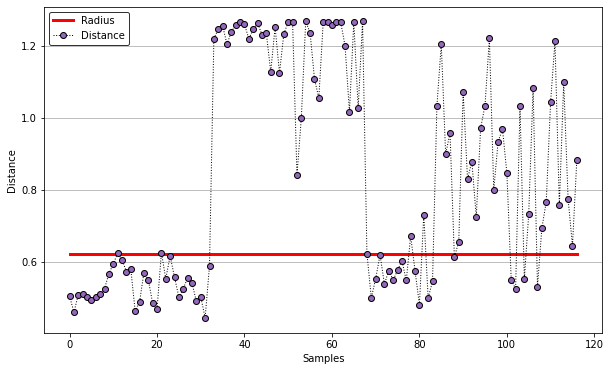

Epoch 1/10
2/2 [==============================] - 57s 35s/step - loss: 1.4934 - accuracy: 0.4233 - val_loss: 1.5129 - val_accuracy: 0.4244
Epoch 2/10
2/2 [==============================] - 40s 31s/step - loss: 1.4935 - accuracy: 0.4311 - val_loss: 1.5133 - val_accuracy: 0.4361
Epoch 3/10
2/2 [==============================] - 41s 32s/step - loss: 1.4939 - accuracy: 0.4373 - val_loss: 1.5143 - val_accuracy: 0.4472
Epoch 4/10
2/2 [==============================] - 40s 31s/step - loss: 1.4952 - accuracy: 0.4456 - val_loss: 1.5163 - val_accuracy: 0.4576
Epoch 5/10
2/2 [==============================] - 40s 31s/step - loss: 1.4985 - accuracy: 0.4543 - val_loss: 1.5197 - val_accuracy: 0.4676
Epoch 6/10
2/2 [==============================] - 41s 32s/step - loss: 1.5035 - accuracy: 0.4616 - val_loss: 1.5250 - val_accuracy: 0.4779
Epoch 7/10
2/2 [==============================] - 40s 31s/step - loss: 1.5223 - accuracy: 0.4673 - val_loss: 1.5323 - val_accuracy: 0.4847
Epoch 8/10
2/2 [===========

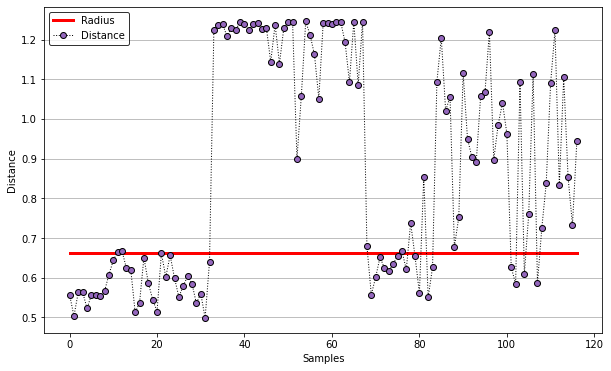

Epoch 1/10
2/2 [==============================] - 57s 34s/step - loss: 1.5048 - accuracy: 0.3504 - val_loss: 1.5123 - val_accuracy: 0.3543
Epoch 2/10
2/2 [==============================] - 42s 32s/step - loss: 1.5042 - accuracy: 0.3467 - val_loss: 1.5124 - val_accuracy: 0.3489
Epoch 3/10
2/2 [==============================] - 41s 32s/step - loss: 1.5041 - accuracy: 0.3431 - val_loss: 1.5127 - val_accuracy: 0.3461
Epoch 4/10
2/2 [==============================] - 41s 32s/step - loss: 1.5044 - accuracy: 0.3390 - val_loss: 1.5135 - val_accuracy: 0.3451
Epoch 5/10
2/2 [==============================] - 41s 32s/step - loss: 1.5052 - accuracy: 0.3370 - val_loss: 1.5151 - val_accuracy: 0.3443
Epoch 6/10
2/2 [==============================] - 41s 32s/step - loss: 1.5072 - accuracy: 0.3348 - val_loss: 1.5181 - val_accuracy: 0.3417
Epoch 7/10
2/2 [==============================] - 41s 32s/step - loss: 1.5118 - accuracy: 0.3344 - val_loss: 1.5233 - val_accuracy: 0.3393
Epoch 8/10
2/2 [===========

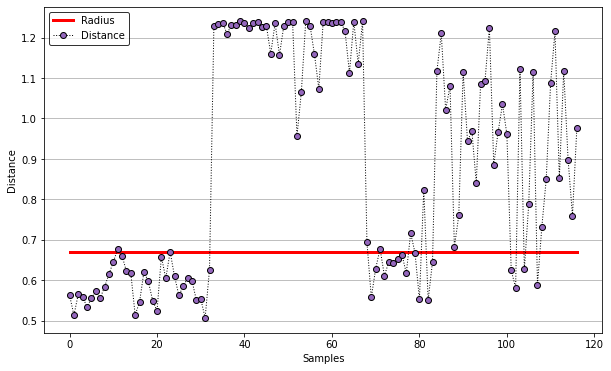

Epoch 1/10
2/2 [==============================] - 57s 35s/step - loss: 1.5154 - accuracy: 0.2295 - val_loss: 1.5117 - val_accuracy: 0.2207
Epoch 2/10
2/2 [==============================] - 42s 32s/step - loss: 1.5151 - accuracy: 0.2320 - val_loss: 1.5119 - val_accuracy: 0.2212
Epoch 3/10
2/2 [==============================] - 42s 32s/step - loss: 1.5153 - accuracy: 0.2348 - val_loss: 1.5127 - val_accuracy: 0.2210
Epoch 4/10
2/2 [==============================] - 41s 32s/step - loss: 1.5163 - accuracy: 0.2375 - val_loss: 1.5145 - val_accuracy: 0.2216
Epoch 5/10
2/2 [==============================] - 41s 32s/step - loss: 1.5187 - accuracy: 0.2393 - val_loss: 1.5178 - val_accuracy: 0.2235
Epoch 6/10
2/2 [==============================] - 41s 32s/step - loss: 1.5256 - accuracy: 0.2406 - val_loss: 1.5235 - val_accuracy: 0.2261
Epoch 7/10
2/2 [==============================] - 41s 32s/step - loss: 1.5427 - accuracy: 0.2430 - val_loss: 1.5320 - val_accuracy: 0.2291
Epoch 8/10
2/2 [===========

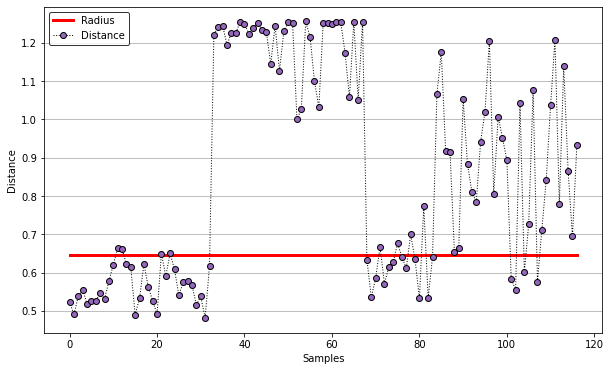

Epoch 1/10
2/2 [==============================] - 56s 35s/step - loss: 1.4884 - accuracy: 0.2085 - val_loss: 1.5135 - val_accuracy: 0.2405
Epoch 2/10
2/2 [==============================] - 41s 32s/step - loss: 1.4879 - accuracy: 0.2268 - val_loss: 1.5134 - val_accuracy: 0.2603
Epoch 3/10
2/2 [==============================] - 41s 32s/step - loss: 1.4877 - accuracy: 0.2466 - val_loss: 1.5133 - val_accuracy: 0.2804
Epoch 4/10
2/2 [==============================] - 41s 32s/step - loss: 1.4876 - accuracy: 0.2664 - val_loss: 1.5133 - val_accuracy: 0.3003
Epoch 5/10
2/2 [==============================] - 41s 32s/step - loss: 1.4875 - accuracy: 0.2847 - val_loss: 1.5132 - val_accuracy: 0.3180
Epoch 6/10
2/2 [==============================] - 41s 32s/step - loss: 1.4875 - accuracy: 0.3036 - val_loss: 1.5133 - val_accuracy: 0.3323
Epoch 7/10
2/2 [==============================] - 41s 32s/step - loss: 1.4875 - accuracy: 0.3211 - val_loss: 1.5134 - val_accuracy: 0.3435
Epoch 8/10
2/2 [===========

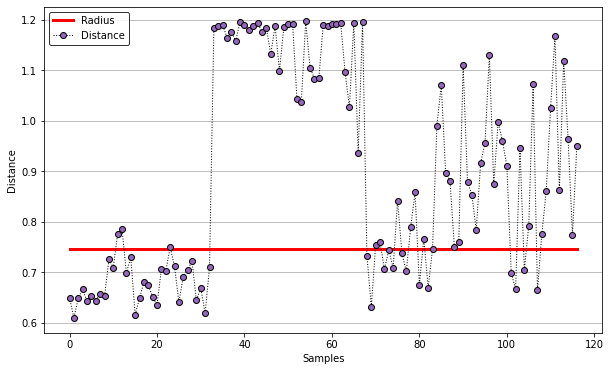

Wall time: 40min 29s


In [12]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
1/1 [==============================] - 22s 22s/step - loss: 0.6287 - accuracy: 0.3413 - val_loss: 0.6390 - val_accuracy: 0.3408
Epoch 2/10
1/1 [==============================] - 11s 11s/step - loss: 0.6284 - accuracy: 0.3467 - val_loss: 0.6388 - val_accuracy: 0.3428
Epoch 3/10
1/1 [==============================] - 11s 11s/step - loss: 0.6282 - accuracy: 0.3480 - val_loss: 0.6387 - val_accuracy: 0.3431
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 0.6280 - accuracy: 0.3494 - val_loss: 0.6386 - val_accuracy: 0.3414
Epoch 5/10
1/1 [==============================] - 11s 11s/step - loss: 0.6280 - accuracy: 0.3482 - val_loss: 0.6385 - val_accuracy: 0.3373
Epoch 6/10
1/1 [==============================] - 11s 11s/step - loss: 0.6281 - accuracy: 0.3440 - val_loss: 0.6386 - val_accuracy: 0.3327
Epoch 7/10
1/1 [==============================] - 11s 11s/step - loss: 0.6283 - accuracy: 0.3432 - val_loss: 0.6386 - val_accuracy: 0.3275
Epoch 8/10
1/1 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.5467 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9224
number of samples    = 60
number of features   = 90112
number of SVs        = 39
ratio of SVs         = 65.0000 %
accuracy             = 36.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.2499 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0625 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.2343 seconds
number of samples    = 42
number of alarm      = 35
accuracy             = 78.5714 %




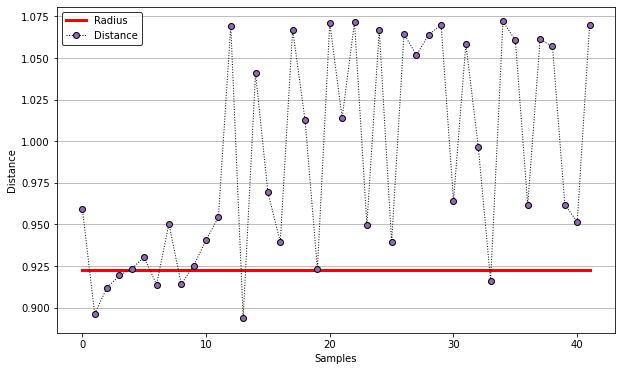

Epoch 1/10
1/1 [==============================] - 21s 21s/step - loss: 0.6382 - accuracy: 0.1656 - val_loss: 0.6371 - val_accuracy: 0.1527
Epoch 2/10
1/1 [==============================] - 11s 11s/step - loss: 0.6379 - accuracy: 0.1614 - val_loss: 0.6370 - val_accuracy: 0.1494
Epoch 3/10
1/1 [==============================] - 11s 11s/step - loss: 0.6377 - accuracy: 0.1568 - val_loss: 0.6370 - val_accuracy: 0.1456
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 0.6376 - accuracy: 0.1526 - val_loss: 0.6370 - val_accuracy: 0.1418
Epoch 5/10
1/1 [==============================] - 11s 11s/step - loss: 0.6376 - accuracy: 0.1489 - val_loss: 0.6370 - val_accuracy: 0.1389
Epoch 6/10
1/1 [==============================] - 11s 11s/step - loss: 0.6376 - accuracy: 0.1441 - val_loss: 0.6371 - val_accuracy: 0.1367
Epoch 7/10
1/1 [==============================] - 11s 11s/step - loss: 0.6376 - accuracy: 0.1402 - val_loss: 0.6372 - val_accuracy: 0.1347
Epoch 8/10
1/1 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4686 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.9171
number of samples    = 60
number of features   = 90112
number of SVs        = 42
ratio of SVs         = 70.0000 %
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 27
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.3437 seconds
number of samples    = 42
number of alarm      = 34
accuracy             = 76.1905 %




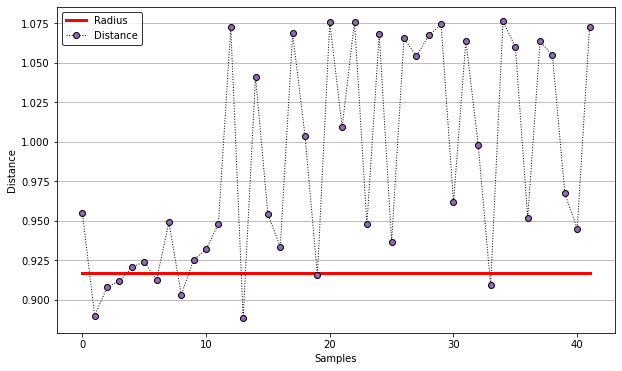

Epoch 1/10
1/1 [==============================] - 21s 21s/step - loss: 0.6522 - accuracy: 0.5348 - val_loss: 0.6367 - val_accuracy: 0.5237
Epoch 2/10
1/1 [==============================] - 11s 11s/step - loss: 0.6516 - accuracy: 0.5353 - val_loss: 0.6364 - val_accuracy: 0.5216
Epoch 3/10
1/1 [==============================] - 11s 11s/step - loss: 0.6511 - accuracy: 0.5400 - val_loss: 0.6363 - val_accuracy: 0.5210
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 0.6509 - accuracy: 0.5425 - val_loss: 0.6362 - val_accuracy: 0.5221
Epoch 5/10
1/1 [==============================] - 11s 11s/step - loss: 0.6508 - accuracy: 0.5453 - val_loss: 0.6361 - val_accuracy: 0.5241
Epoch 6/10
1/1 [==============================] - 11s 11s/step - loss: 0.6509 - accuracy: 0.5491 - val_loss: 0.6361 - val_accuracy: 0.5272
Epoch 7/10
1/1 [==============================] - 11s 11s/step - loss: 0.6507 - accuracy: 0.5544 - val_loss: 0.6361 - val_accuracy: 0.5310
Epoch 8/10
1/1 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.5311 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9161
number of samples    = 60
number of features   = 90112
number of SVs        = 38
ratio of SVs         = 63.3333 %
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 27
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.2343 seconds
number of samples    = 42
number of alarm      = 34
accuracy             = 76.1905 %




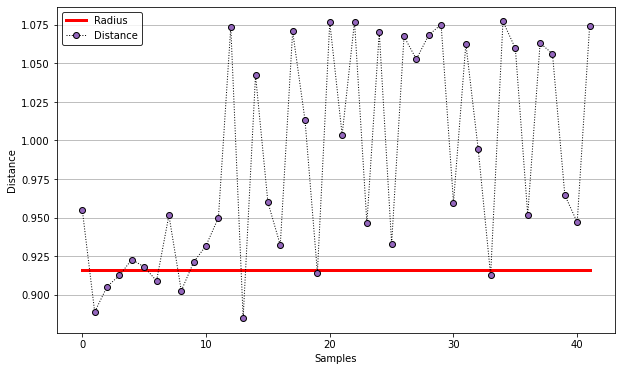

Epoch 1/10
1/1 [==============================] - 21s 21s/step - loss: 0.6335 - accuracy: 0.4006 - val_loss: 0.6372 - val_accuracy: 0.3900
Epoch 2/10
1/1 [==============================] - 11s 11s/step - loss: 0.6333 - accuracy: 0.3957 - val_loss: 0.6370 - val_accuracy: 0.3820
Epoch 3/10
1/1 [==============================] - 11s 11s/step - loss: 0.6331 - accuracy: 0.3911 - val_loss: 0.6370 - val_accuracy: 0.3729
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 0.6331 - accuracy: 0.3800 - val_loss: 0.6369 - val_accuracy: 0.3641
Epoch 5/10
1/1 [==============================] - 11s 11s/step - loss: 0.6330 - accuracy: 0.3774 - val_loss: 0.6369 - val_accuracy: 0.3569
Epoch 6/10
1/1 [==============================] - 11s 11s/step - loss: 0.6330 - accuracy: 0.3708 - val_loss: 0.6370 - val_accuracy: 0.3504
Epoch 7/10
1/1 [==============================] - 11s 11s/step - loss: 0.6330 - accuracy: 0.3633 - val_loss: 0.6370 - val_accuracy: 0.3446
Epoch 8/10
1/1 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4843 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.9166
number of samples    = 60
number of features   = 90112
number of SVs        = 39
ratio of SVs         = 65.0000 %
accuracy             = 43.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.1875 seconds
number of samples    = 30
number of alarm      = 28
accuracy             = 93.3333 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.3280 seconds
number of samples    = 42
number of alarm      = 35
accuracy             = 78.5714 %




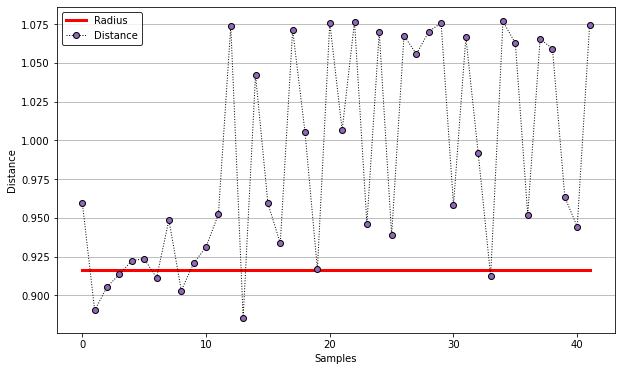

Epoch 1/10
1/1 [==============================] - 21s 21s/step - loss: 0.6497 - accuracy: 0.2873 - val_loss: 0.6351 - val_accuracy: 0.2755
Epoch 2/10
1/1 [==============================] - 11s 11s/step - loss: 0.6494 - accuracy: 0.2836 - val_loss: 0.6350 - val_accuracy: 0.2735
Epoch 3/10
1/1 [==============================] - 11s 11s/step - loss: 0.6493 - accuracy: 0.2801 - val_loss: 0.6349 - val_accuracy: 0.2712
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 0.6492 - accuracy: 0.2770 - val_loss: 0.6349 - val_accuracy: 0.2672
Epoch 5/10
1/1 [==============================] - 11s 11s/step - loss: 0.6492 - accuracy: 0.2728 - val_loss: 0.6350 - val_accuracy: 0.2634
Epoch 6/10
1/1 [==============================] - 11s 11s/step - loss: 0.6492 - accuracy: 0.2670 - val_loss: 0.6350 - val_accuracy: 0.2602
Epoch 7/10
1/1 [==============================] - 11s 11s/step - loss: 0.6493 - accuracy: 0.2646 - val_loss: 0.6352 - val_accuracy: 0.2566
Epoch 8/10
1/1 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 0.4686 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.9195
number of samples    = 60
number of features   = 90112
number of SVs        = 37
ratio of SVs         = 61.6667 %
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.1718 seconds
number of samples    = 30
number of alarm      = 27
accuracy             = 90.0000 %




*** Prediction of the provided data is completed. ***

running time         = 0.0781 seconds
number of samples    = 12
number of alarm      = 7
accuracy             = 41.6667 %




*** Prediction of the provided data is completed. ***

running time         = 0.3281 seconds
number of samples    = 42
number of alarm      = 34
accuracy             = 76.1905 %




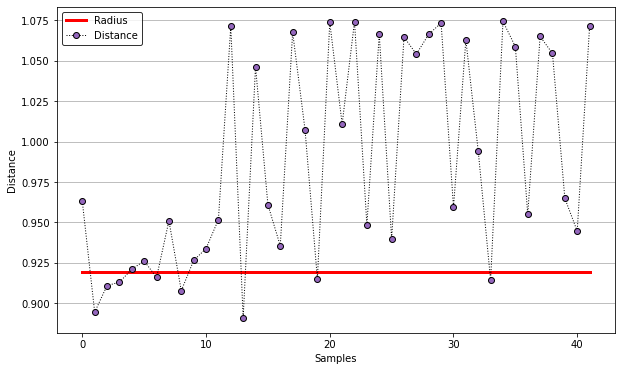

Wall time: 11min 31s


In [13]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-3), gamma=10**(-4), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
2/2 [==============================] - 51s 31s/step - loss: 0.9872 - accuracy: 0.1558 - val_loss: 0.9973 - val_accuracy: 0.2217
Epoch 2/10
2/2 [==============================] - 38s 28s/step - loss: 0.9865 - accuracy: 0.2374 - val_loss: 0.9970 - val_accuracy: 0.2956
Epoch 3/10
2/2 [==============================] - 37s 28s/step - loss: 0.9873 - accuracy: 0.3111 - val_loss: 0.9975 - val_accuracy: 0.3600
Epoch 4/10
2/2 [==============================] - 37s 28s/step - loss: 0.9911 - accuracy: 0.3750 - val_loss: 0.9997 - val_accuracy: 0.4137
Epoch 5/10
2/2 [==============================] - 37s 28s/step - loss: 0.9992 - accuracy: 0.4259 - val_loss: 1.0042 - val_accuracy: 0.4591
Epoch 6/10
2/2 [==============================] - 37s 27s/step - loss: 1.0131 - accuracy: 0.4691 - val_loss: 1.0119 - val_accuracy: 0.4956
Epoch 7/10
2/2 [==============================] - 37s 27s/step - loss: 1.0319 - accuracy: 0.5063 - val_loss: 1.0237 - val_accuracy: 0.5233
Epoch 8/10
2/2 [===========

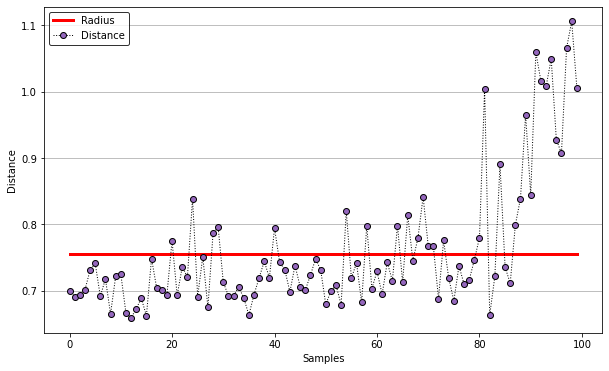

Epoch 1/10
2/2 [==============================] - 55s 31s/step - loss: 1.0048 - accuracy: 0.0492 - val_loss: 0.9965 - val_accuracy: 0.0978
Epoch 2/10
2/2 [==============================] - 39s 29s/step - loss: 1.0023 - accuracy: 0.1013 - val_loss: 0.9949 - val_accuracy: 0.1818
Epoch 3/10
2/2 [==============================] - 37s 28s/step - loss: 1.0006 - accuracy: 0.1886 - val_loss: 0.9935 - val_accuracy: 0.3006
Epoch 4/10
2/2 [==============================] - 37s 28s/step - loss: 0.9991 - accuracy: 0.3086 - val_loss: 0.9921 - val_accuracy: 0.4386
Epoch 5/10
2/2 [==============================] - 38s 28s/step - loss: 0.9975 - accuracy: 0.4462 - val_loss: 0.9908 - val_accuracy: 0.5801
Epoch 6/10
2/2 [==============================] - 38s 28s/step - loss: 0.9959 - accuracy: 0.5887 - val_loss: 0.9895 - val_accuracy: 0.7097
Epoch 7/10
2/2 [==============================] - 37s 28s/step - loss: 0.9949 - accuracy: 0.7249 - val_loss: 0.9886 - val_accuracy: 0.8132
Epoch 8/10
2/2 [===========

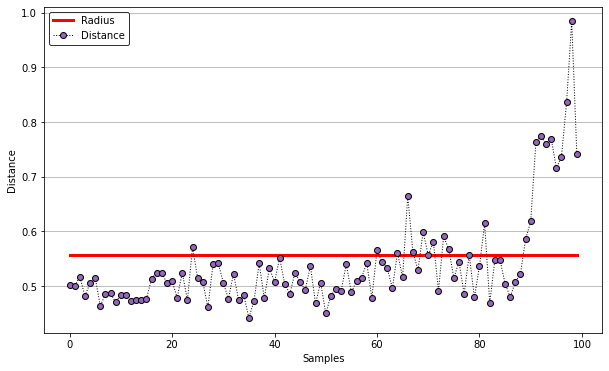

Epoch 1/10
2/2 [==============================] - 54s 31s/step - loss: 1.0015 - accuracy: 0.2332 - val_loss: 0.9954 - val_accuracy: 0.3062
Epoch 2/10
2/2 [==============================] - 38s 29s/step - loss: 0.9999 - accuracy: 0.3290 - val_loss: 0.9942 - val_accuracy: 0.4216
Epoch 3/10
2/2 [==============================] - 38s 29s/step - loss: 0.9987 - accuracy: 0.4448 - val_loss: 0.9932 - val_accuracy: 0.5432
Epoch 4/10
2/2 [==============================] - 38s 29s/step - loss: 0.9976 - accuracy: 0.5600 - val_loss: 0.9922 - val_accuracy: 0.6483
Epoch 5/10
2/2 [==============================] - 39s 29s/step - loss: 0.9967 - accuracy: 0.6513 - val_loss: 0.9913 - val_accuracy: 0.7226
Epoch 6/10
2/2 [==============================] - 38s 29s/step - loss: 0.9963 - accuracy: 0.7154 - val_loss: 0.9907 - val_accuracy: 0.7701
Epoch 7/10
2/2 [==============================] - 38s 29s/step - loss: 0.9968 - accuracy: 0.7575 - val_loss: 0.9907 - val_accuracy: 0.7989
Epoch 8/10
2/2 [===========

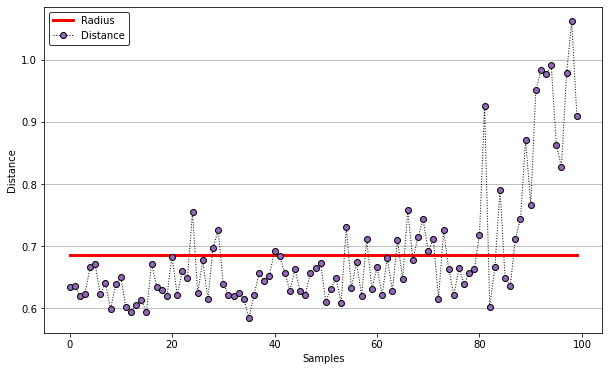

Epoch 1/10
2/2 [==============================] - 53s 31s/step - loss: 1.0002 - accuracy: 0.4038 - val_loss: 0.9925 - val_accuracy: 0.5077
Epoch 2/10
2/2 [==============================] - 39s 29s/step - loss: 0.9991 - accuracy: 0.5197 - val_loss: 0.9915 - val_accuracy: 0.6266
Epoch 3/10
2/2 [==============================] - 37s 27s/step - loss: 0.9978 - accuracy: 0.6402 - val_loss: 0.9904 - val_accuracy: 0.7326
Epoch 4/10
2/2 [==============================] - 37s 28s/step - loss: 0.9963 - accuracy: 0.7468 - val_loss: 0.9891 - val_accuracy: 0.8173
Epoch 5/10
2/2 [==============================] - 37s 28s/step - loss: 0.9950 - accuracy: 0.8291 - val_loss: 0.9881 - val_accuracy: 0.8789
Epoch 6/10
2/2 [==============================] - 37s 28s/step - loss: 0.9950 - accuracy: 0.8881 - val_loss: 0.9876 - val_accuracy: 0.9182
Epoch 7/10
2/2 [==============================] - 37s 28s/step - loss: 0.9962 - accuracy: 0.9231 - val_loss: 0.9874 - val_accuracy: 0.9389
Epoch 8/10
2/2 [===========

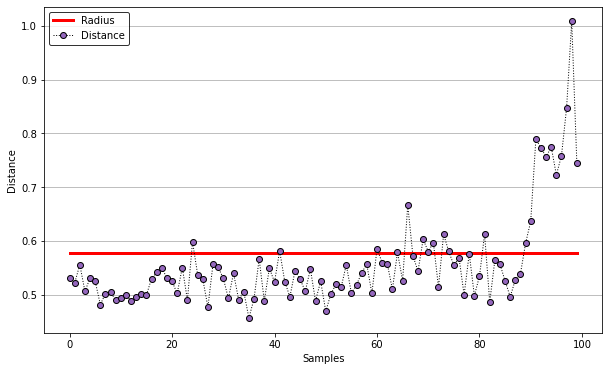

Epoch 1/10
2/2 [==============================] - 53s 31s/step - loss: 0.9877 - accuracy: 0.7520 - val_loss: 0.9900 - val_accuracy: 0.8023
Epoch 2/10
2/2 [==============================] - 39s 29s/step - loss: 0.9869 - accuracy: 0.8100 - val_loss: 0.9895 - val_accuracy: 0.8441
Epoch 3/10
2/2 [==============================] - 39s 29s/step - loss: 0.9871 - accuracy: 0.8461 - val_loss: 0.9895 - val_accuracy: 0.8661
Epoch 4/10
2/2 [==============================] - 39s 29s/step - loss: 0.9887 - accuracy: 0.8622 - val_loss: 0.9902 - val_accuracy: 0.8728
Epoch 5/10
2/2 [==============================] - 38s 29s/step - loss: 0.9932 - accuracy: 0.8657 - val_loss: 0.9916 - val_accuracy: 0.8667
Epoch 6/10
2/2 [==============================] - 38s 29s/step - loss: 1.0007 - accuracy: 0.8584 - val_loss: 0.9940 - val_accuracy: 0.8479
Epoch 7/10
2/2 [==============================] - 38s 28s/step - loss: 1.0100 - accuracy: 0.8418 - val_loss: 0.9978 - val_accuracy: 0.8165
Epoch 8/10
2/2 [===========

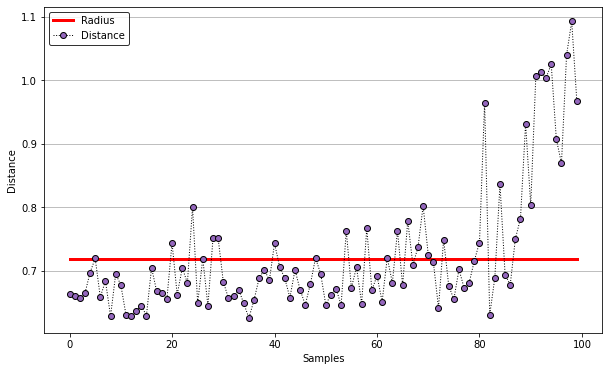

Wall time: 45min 11s


In [14]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)
    
    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-2), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
2/2 [==============================] - 60s 38s/step - loss: 1.6276 - accuracy: 0.1644 - val_loss: 1.6462 - val_accuracy: 0.1956
Epoch 2/10
2/2 [==============================] - 44s 34s/step - loss: 1.6258 - accuracy: 0.1968 - val_loss: 1.6451 - val_accuracy: 0.2202
Epoch 3/10
2/2 [==============================] - 45s 35s/step - loss: 1.6245 - accuracy: 0.2273 - val_loss: 1.6441 - val_accuracy: 0.2459
Epoch 4/10
2/2 [==============================] - 44s 34s/step - loss: 1.6233 - accuracy: 0.2536 - val_loss: 1.6433 - val_accuracy: 0.2754
Epoch 5/10
2/2 [==============================] - 43s 34s/step - loss: 1.6222 - accuracy: 0.2754 - val_loss: 1.6428 - val_accuracy: 0.3058
Epoch 6/10
2/2 [==============================] - 43s 34s/step - loss: 1.6209 - accuracy: 0.2962 - val_loss: 1.6430 - val_accuracy: 0.3331
Epoch 7/10
2/2 [==============================] - 44s 35s/step - loss: 1.6201 - accuracy: 0.3144 - val_loss: 1.6444 - val_accuracy: 0.3570
Epoch 8/10
2/2 [===========

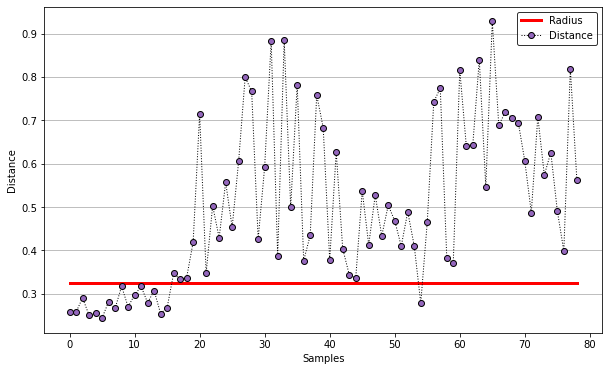

Epoch 1/10
2/2 [==============================] - 60s 37s/step - loss: 1.6472 - accuracy: 0.3048 - val_loss: 1.6438 - val_accuracy: 0.3158
Epoch 2/10
2/2 [==============================] - 44s 35s/step - loss: 1.6452 - accuracy: 0.3821 - val_loss: 1.6427 - val_accuracy: 0.3698
Epoch 3/10
2/2 [==============================] - 45s 35s/step - loss: 1.6435 - accuracy: 0.4606 - val_loss: 1.6415 - val_accuracy: 0.4330
Epoch 4/10
2/2 [==============================] - 44s 35s/step - loss: 1.6414 - accuracy: 0.5362 - val_loss: 1.6403 - val_accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 44s 34s/step - loss: 1.6389 - accuracy: 0.6060 - val_loss: 1.6394 - val_accuracy: 0.5623
Epoch 6/10
2/2 [==============================] - 44s 34s/step - loss: 1.6356 - accuracy: 0.6654 - val_loss: 1.6392 - val_accuracy: 0.6175
Epoch 7/10
2/2 [==============================] - 44s 34s/step - loss: 1.6337 - accuracy: 0.7123 - val_loss: 1.6404 - val_accuracy: 0.6666
Epoch 8/10
2/2 [===========

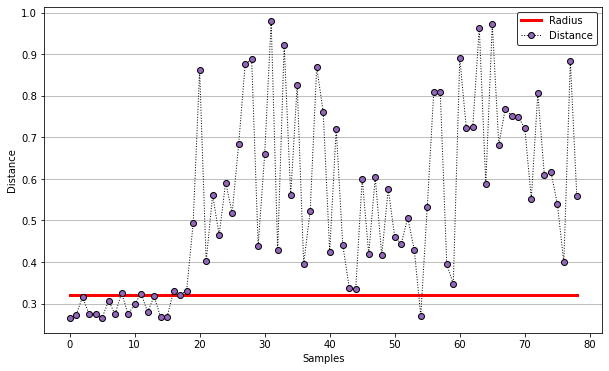

Epoch 1/10
2/2 [==============================] - 58s 37s/step - loss: 1.6439 - accuracy: 0.6194 - val_loss: 1.6412 - val_accuracy: 0.6753
Epoch 2/10
2/2 [==============================] - 45s 35s/step - loss: 1.6410 - accuracy: 0.6864 - val_loss: 1.6410 - val_accuracy: 0.7411
Epoch 3/10
2/2 [==============================] - 44s 34s/step - loss: 1.6372 - accuracy: 0.7471 - val_loss: 1.6422 - val_accuracy: 0.8062
Epoch 4/10
2/2 [==============================] - 44s 35s/step - loss: 1.6394 - accuracy: 0.8003 - val_loss: 1.6465 - val_accuracy: 0.8579
Epoch 5/10
2/2 [==============================] - 43s 34s/step - loss: 1.6555 - accuracy: 0.8469 - val_loss: 1.6556 - val_accuracy: 0.8920
Epoch 6/10
2/2 [==============================] - 44s 35s/step - loss: 1.7099 - accuracy: 0.8838 - val_loss: 1.6699 - val_accuracy: 0.9155
Epoch 7/10
2/2 [==============================] - 44s 34s/step - loss: 1.7950 - accuracy: 0.9078 - val_loss: 1.6878 - val_accuracy: 0.9299
Epoch 8/10
2/2 [===========

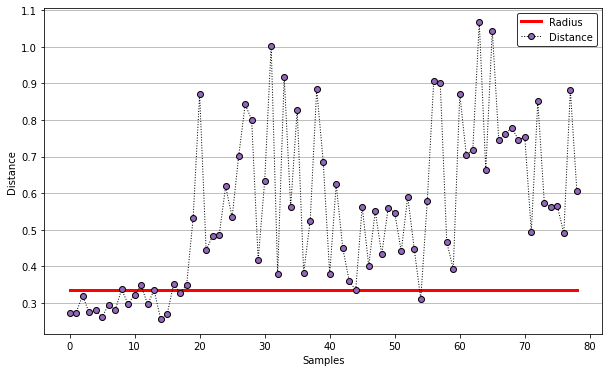

Epoch 1/10
2/2 [==============================] - 60s 37s/step - loss: 1.6650 - accuracy: 0.4208 - val_loss: 1.6425 - val_accuracy: 0.4386
Epoch 2/10
2/2 [==============================] - 45s 35s/step - loss: 1.6637 - accuracy: 0.4768 - val_loss: 1.6422 - val_accuracy: 0.4744
Epoch 3/10
2/2 [==============================] - 45s 35s/step - loss: 1.6622 - accuracy: 0.5268 - val_loss: 1.6422 - val_accuracy: 0.5110
Epoch 4/10
2/2 [==============================] - 45s 35s/step - loss: 1.6609 - accuracy: 0.5696 - val_loss: 1.6428 - val_accuracy: 0.5440
Epoch 5/10
2/2 [==============================] - 44s 35s/step - loss: 1.6617 - accuracy: 0.6014 - val_loss: 1.6450 - val_accuracy: 0.5712
Epoch 6/10
2/2 [==============================] - 44s 35s/step - loss: 1.6690 - accuracy: 0.6249 - val_loss: 1.6494 - val_accuracy: 0.5912
Epoch 7/10
2/2 [==============================] - 43s 33s/step - loss: 1.6965 - accuracy: 0.6402 - val_loss: 1.6564 - val_accuracy: 0.6066
Epoch 8/10
2/2 [===========

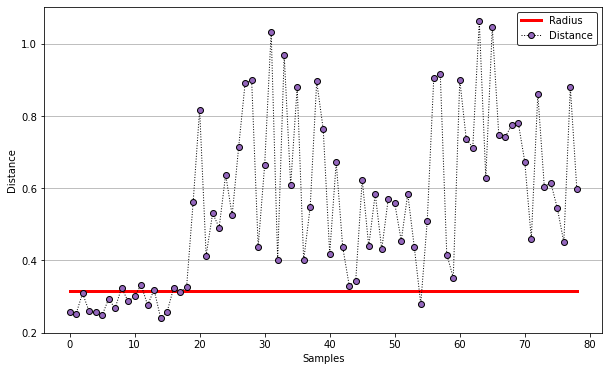

Epoch 1/10
2/2 [==============================] - 61s 38s/step - loss: 1.6195 - accuracy: 0.1843 - val_loss: 1.6463 - val_accuracy: 0.1829
Epoch 2/10
2/2 [==============================] - 45s 34s/step - loss: 1.6180 - accuracy: 0.1948 - val_loss: 1.6454 - val_accuracy: 0.1945
Epoch 3/10
2/2 [==============================] - 43s 34s/step - loss: 1.6167 - accuracy: 0.2043 - val_loss: 1.6447 - val_accuracy: 0.2033
Epoch 4/10
2/2 [==============================] - 43s 34s/step - loss: 1.6150 - accuracy: 0.2131 - val_loss: 1.6443 - val_accuracy: 0.2095
Epoch 5/10
2/2 [==============================] - 45s 35s/step - loss: 1.6130 - accuracy: 0.2207 - val_loss: 1.6449 - val_accuracy: 0.2155
Epoch 6/10
2/2 [==============================] - 43s 34s/step - loss: 1.6112 - accuracy: 0.2292 - val_loss: 1.6472 - val_accuracy: 0.2232
Epoch 7/10
2/2 [==============================] - 43s 34s/step - loss: 1.6126 - accuracy: 0.2324 - val_loss: 1.6523 - val_accuracy: 0.2300
Epoch 8/10
2/2 [===========

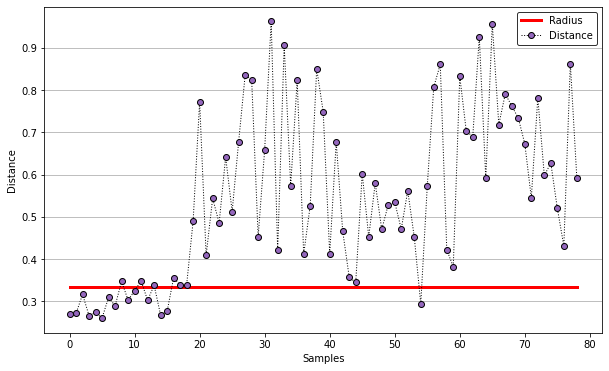

Wall time: 42min 38s


In [15]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-5), gamma=10**(-5), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

Epoch 1/10
2/2 [==============================] - 60s 37s/step - loss: 1.3221 - accuracy: 0.5480 - val_loss: 1.3242 - val_accuracy: 0.5198
Epoch 2/10
2/2 [==============================] - 44s 34s/step - loss: 1.3220 - accuracy: 0.5163 - val_loss: 1.3240 - val_accuracy: 0.4944
Epoch 3/10
2/2 [==============================] - 43s 33s/step - loss: 1.3221 - accuracy: 0.4999 - val_loss: 1.3241 - val_accuracy: 0.4840
Epoch 4/10
2/2 [==============================] - 43s 33s/step - loss: 1.3229 - accuracy: 0.4960 - val_loss: 1.3242 - val_accuracy: 0.4796
Epoch 5/10
2/2 [==============================] - 43s 33s/step - loss: 1.3248 - accuracy: 0.4956 - val_loss: 1.3247 - val_accuracy: 0.4777
Epoch 6/10
2/2 [==============================] - 42s 33s/step - loss: 1.3286 - accuracy: 0.4974 - val_loss: 1.3255 - val_accuracy: 0.4766
Epoch 7/10
2/2 [==============================] - 43s 33s/step - loss: 1.3350 - accuracy: 0.4943 - val_loss: 1.3269 - val_accuracy: 0.4700
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4682 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.0096
number of samples    = 240
number of features   = 90112
number of SVs        = 240
ratio of SVs         = 100.0000 %
accuracy             = 62.5000 %




*** Prediction of the provided data is completed. ***

running time         = 1.2343 seconds
number of samples    = 119
number of alarm      = 108
accuracy             = 90.7563 %




*** Prediction of the provided data is completed. ***

running time         = 0.4062 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 1.4840 seconds
number of samples    = 151
number of alarm      = 118
accuracy             = 86.0927 %




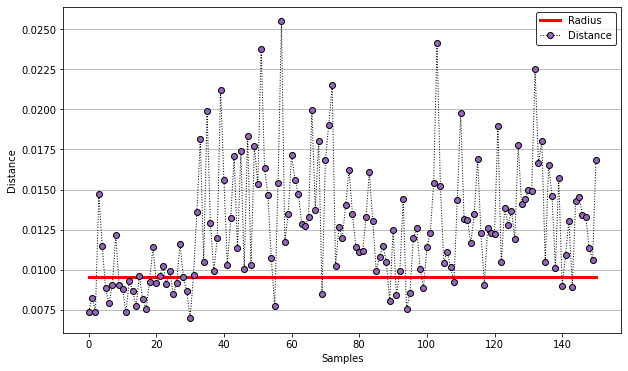

Epoch 1/10
2/2 [==============================] - 61s 37s/step - loss: 1.3216 - accuracy: 0.2173 - val_loss: 1.3242 - val_accuracy: 0.2219
Epoch 2/10
2/2 [==============================] - 44s 34s/step - loss: 1.3217 - accuracy: 0.2275 - val_loss: 1.3243 - val_accuracy: 0.2300
Epoch 3/10
2/2 [==============================] - 43s 33s/step - loss: 1.3222 - accuracy: 0.2356 - val_loss: 1.3247 - val_accuracy: 0.2366
Epoch 4/10
2/2 [==============================] - 43s 33s/step - loss: 1.3242 - accuracy: 0.2445 - val_loss: 1.3254 - val_accuracy: 0.2438
Epoch 5/10
2/2 [==============================] - 43s 34s/step - loss: 1.3289 - accuracy: 0.2527 - val_loss: 1.3267 - val_accuracy: 0.2519
Epoch 6/10
2/2 [==============================] - 44s 34s/step - loss: 1.3407 - accuracy: 0.2617 - val_loss: 1.3291 - val_accuracy: 0.2601
Epoch 7/10
2/2 [==============================] - 42s 33s/step - loss: 1.3665 - accuracy: 0.2650 - val_loss: 1.3331 - val_accuracy: 0.2675
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4470 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0111
number of samples    = 240
number of features   = 90112
number of SVs        = 142
ratio of SVs         = 59.1667 %
accuracy             = 77.0833 %




*** Prediction of the provided data is completed. ***

running time         = 1.2810 seconds
number of samples    = 119
number of alarm      = 101
accuracy             = 84.8739 %




*** Prediction of the provided data is completed. ***

running time         = 0.4218 seconds
number of samples    = 32
number of alarm      = 6
accuracy             = 81.2500 %




*** Prediction of the provided data is completed. ***

running time         = 1.4216 seconds
number of samples    = 151
number of alarm      = 107
accuracy             = 84.1060 %




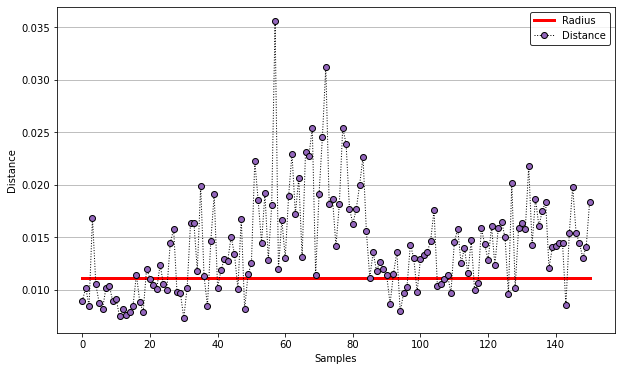

Epoch 1/10
2/2 [==============================] - 58s 36s/step - loss: 1.3220 - accuracy: 0.0908 - val_loss: 1.3242 - val_accuracy: 0.1081
Epoch 2/10
2/2 [==============================] - 42s 32s/step - loss: 1.3219 - accuracy: 0.1077 - val_loss: 1.3240 - val_accuracy: 0.1356
Epoch 3/10
2/2 [==============================] - 42s 33s/step - loss: 1.3218 - accuracy: 0.1355 - val_loss: 1.3240 - val_accuracy: 0.1642
Epoch 4/10
2/2 [==============================] - 42s 33s/step - loss: 1.3220 - accuracy: 0.1641 - val_loss: 1.3240 - val_accuracy: 0.1915
Epoch 5/10
2/2 [==============================] - 43s 34s/step - loss: 1.3224 - accuracy: 0.1926 - val_loss: 1.3242 - val_accuracy: 0.2184
Epoch 6/10
2/2 [==============================] - 42s 33s/step - loss: 1.3234 - accuracy: 0.2184 - val_loss: 1.3246 - val_accuracy: 0.2461
Epoch 7/10
2/2 [==============================] - 43s 33s/step - loss: 1.3257 - accuracy: 0.2445 - val_loss: 1.3252 - val_accuracy: 0.2706
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4994 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0092
number of samples    = 240
number of features   = 90112
number of SVs        = 240
ratio of SVs         = 100.0000 %
accuracy             = 62.0833 %




*** Prediction of the provided data is completed. ***

running time         = 1.2028 seconds
number of samples    = 119
number of alarm      = 108
accuracy             = 90.7563 %




*** Prediction of the provided data is completed. ***

running time         = 0.3905 seconds
number of samples    = 32
number of alarm      = 7
accuracy             = 78.1250 %




*** Prediction of the provided data is completed. ***

running time         = 1.5112 seconds
number of samples    = 151
number of alarm      = 115
accuracy             = 88.0795 %




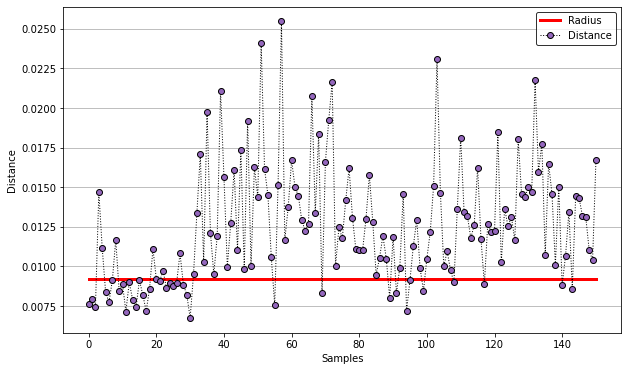

Epoch 1/10
2/2 [==============================] - 59s 36s/step - loss: 1.3222 - accuracy: 0.2285 - val_loss: 1.3240 - val_accuracy: 0.2510
Epoch 2/10
2/2 [==============================] - 43s 33s/step - loss: 1.3221 - accuracy: 0.2576 - val_loss: 1.3239 - val_accuracy: 0.2659
Epoch 3/10
2/2 [==============================] - 44s 34s/step - loss: 1.3223 - accuracy: 0.2732 - val_loss: 1.3239 - val_accuracy: 0.2703
Epoch 4/10
2/2 [==============================] - 42s 33s/step - loss: 1.3228 - accuracy: 0.2778 - val_loss: 1.3241 - val_accuracy: 0.2710
Epoch 5/10
2/2 [==============================] - 42s 33s/step - loss: 1.3243 - accuracy: 0.2733 - val_loss: 1.3245 - val_accuracy: 0.2654
Epoch 6/10
2/2 [==============================] - 42s 33s/step - loss: 1.3278 - accuracy: 0.2626 - val_loss: 1.3253 - val_accuracy: 0.2587
Epoch 7/10
2/2 [==============================] - 42s 33s/step - loss: 1.3344 - accuracy: 0.2561 - val_loss: 1.3266 - val_accuracy: 0.2576
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4682 seconds
kernel function      = rbf
iterations           = 8
radius               = 0.0093
number of samples    = 240
number of features   = 90112
number of SVs        = 231
ratio of SVs         = 96.2500 %
accuracy             = 65.0000 %




*** Prediction of the provided data is completed. ***

running time         = 1.2497 seconds
number of samples    = 119
number of alarm      = 108
accuracy             = 90.7563 %




*** Prediction of the provided data is completed. ***

running time         = 0.4062 seconds
number of samples    = 32
number of alarm      = 10
accuracy             = 68.7500 %




*** Prediction of the provided data is completed. ***

running time         = 1.4216 seconds
number of samples    = 151
number of alarm      = 118
accuracy             = 86.0927 %




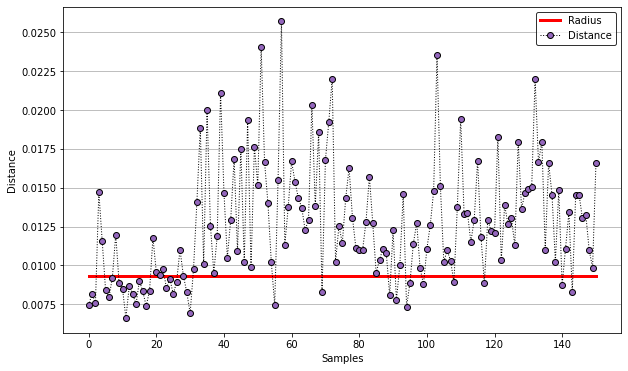

Epoch 1/10
2/2 [==============================] - 60s 37s/step - loss: 1.3270 - accuracy: 0.2052 - val_loss: 1.3234 - val_accuracy: 0.2226
Epoch 2/10
2/2 [==============================] - 43s 33s/step - loss: 1.3269 - accuracy: 0.2236 - val_loss: 1.3233 - val_accuracy: 0.2452
Epoch 3/10
2/2 [==============================] - 43s 34s/step - loss: 1.3269 - accuracy: 0.2399 - val_loss: 1.3233 - val_accuracy: 0.2631
Epoch 4/10
2/2 [==============================] - 44s 33s/step - loss: 1.3272 - accuracy: 0.2539 - val_loss: 1.3234 - val_accuracy: 0.2739
Epoch 5/10
2/2 [==============================] - 43s 33s/step - loss: 1.3281 - accuracy: 0.2609 - val_loss: 1.3237 - val_accuracy: 0.2791
Epoch 6/10
2/2 [==============================] - 42s 33s/step - loss: 1.3300 - accuracy: 0.2650 - val_loss: 1.3242 - val_accuracy: 0.2813
Epoch 7/10
2/2 [==============================] - 43s 33s/step - loss: 1.3332 - accuracy: 0.2683 - val_loss: 1.3251 - val_accuracy: 0.2833
Epoch 8/10
2/2 [===========

C:\Users\kitam\M_learning\M_learning\deep_svdd.py:261: UserWarning: The fitted SVDD model may be overfitting.

  warnings.warn("The fitted SVDD model may be overfitting.\n")




*** Fitting of the SVDD model is completed. ***

running time         = 2.4838 seconds
kernel function      = rbf
iterations           = 7
radius               = 0.0089
number of samples    = 240
number of features   = 90112
number of SVs        = 240
ratio of SVs         = 100.0000 %
accuracy             = 60.4167 %




*** Prediction of the provided data is completed. ***

running time         = 1.2028 seconds
number of samples    = 119
number of alarm      = 110
accuracy             = 92.4370 %




*** Prediction of the provided data is completed. ***

running time         = 0.4686 seconds
number of samples    = 32
number of alarm      = 9
accuracy             = 71.8750 %




*** Prediction of the provided data is completed. ***

running time         = 1.4059 seconds
number of samples    = 151
number of alarm      = 119
accuracy             = 88.0795 %




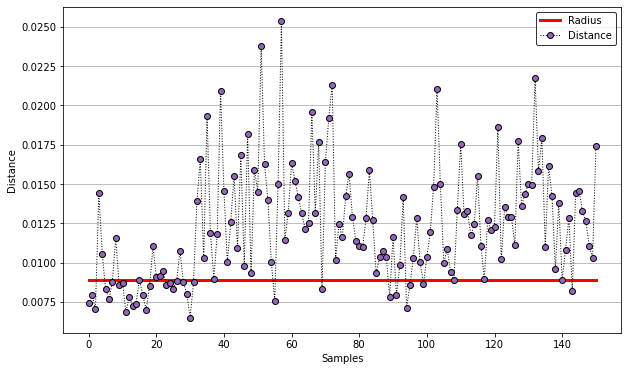

Wall time: 43min 35s


In [16]:
%%time
for num in range(5):
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.bottle()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.cable()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.capsule()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.carpet()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.grid()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.hazelnut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.leather()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.metal_nut()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.pill()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.screw()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.tile()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.toothbrush()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.transistor()
#     X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.wood()
    X_train, X_test, X_test_good, X_test_error, y_tr, y_tg, y_te, y_ts = mv.zipper()
    x_train, x_test = train_test_split(X_train, test_size=0.9)

    model = Sequential()
    model.add(EfficientNetB2(include_top=False,weights='imagenet', input_shape=(256,256,3)))
    model.add(Reshape((8,8,1408)))
    model.add(Conv2D(256, kernel_size=(3, 3),activation='relu', padding='same'))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2DTranspose(64, kernel_size=(3, 3),activation='relu', padding='same',strides=2))
    model.add(Conv2D(3, kernel_size=(3, 3),activation='sigmoid', padding='same'))
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, x_train,epochs=10,batch_size=16,shuffle=True,validation_data=(x_test, x_test))
    encoder = models.clone_model(model)
    encoder.compile(optimizer='adam', loss='binary_crossentropy')
    encoder.set_weights(model.get_weights())
    for i in range(7):
        encoder.pop()
    X_tr = encoder.predict(X_train,verbose=0)
    X_tg = encoder.predict(X_test_good,verbose=0)
    X_te = encoder.predict(X_test_error,verbose=0)
    X_ts = encoder.predict(X_test,verbose=0)
    x_tr = np.reshape(X_tr,(X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]*X_tr.shape[3]))
    x_tg = np.reshape(X_tg,(X_tg.shape[0], X_tg.shape[1]*X_tg.shape[2]*X_tg.shape[3]))
    x_te = np.reshape(X_te,(X_te.shape[0], X_te.shape[1]*X_te.shape[2]*X_te.shape[3]))
    x_ts = np.reshape(X_ts,(X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]*X_ts.shape[3]))

    svdd = BaseSVDD(C=2**(-7), gamma=10**(-8), kernel='rbf', display='on')
    svdd.fit(x_tr)
    svdd.predict(x_te, y_te)
    acc.append(svdd.accuracy)
    svdd.predict(x_tg, y_tg)
    acc.append(svdd.accuracy)
    svdd.predict(x_ts, y_ts)
    acc.append(svdd.accuracy)
    radius = svdd.radius
    distance = svdd.get_distance(x_ts)
    svdd.plot_distance(radius, distance)

In [24]:
a = acc

In [25]:
a = np.array(a)
a=a*100
a= a.reshape(75,3)
a.shape
df = pd.DataFrame(a)
print(df)
df.to_csv('output_pd.csv')

            0       1          2
0   98.412698  90.000  96.385542
1   98.412698  90.000  96.385542
2   98.412698  95.000  97.590361
3   98.412698  90.000  96.385542
4   98.412698  90.000  96.385542
..        ...     ...        ...
70  90.756303  68.750  86.092715
71  84.873950  81.250  84.105960
72  90.756303  78.125  88.079470
73  90.756303  68.750  86.092715
74  92.436975  71.875  88.079470

[75 rows x 3 columns]
